In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
from math import radians, sin, cos, sqrt, atan2
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GridSearchCV
from scipy.spatial.distance import pdist, squareform
import dask.array as da
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from math import radians, sin, cos, sqrt, atan2
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from joblib import Parallel, delayed
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler


#Extra settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

In [2]:
#Loading train and test data
try:
    train_df=pd.read_csv('/home/anuragverma/Desktop/Kaggle/GeoAI Ground-level NO2 _Zindi/Datasets/Train.csv')
    test_df=pd.read_csv('/home/anuragverma/Desktop/Kaggle/GeoAI Ground-level NO2 _Zindi/Datasets/Test.csv')
    print("Train df shape: " ,train_df.shape)
    print("Test df shape: ", test_df.shape)

except FileNotFoundError:
    print('File not loaded')

Train df shape:  (86584, 14)
Test df shape:  (6576, 13)


In [3]:

def Prep_linear(df1):
    df=df1.copy()
    numeric_columns =['Precipitation','LST','AAI','CloudFraction','TropopausePressure','GT_NO2']
    
    for col in numeric_columns:
        # Fill missing values temporarily using linear interpolation
        data_interpolated = df[col].interpolate(method='linear')
        
        # Handle cases where interpolation might still leave NaNs at the ends
        if data_interpolated.isna().sum() > 0:
            data_interpolated.fillna(method='bfill', inplace=True)
            data_interpolated.fillna(method='ffill', inplace=True)

        # Decompose the time series to extract the trend component
        decomposition = seasonal_decompose(data_interpolated, model='additive', period=30)
        trend = decomposition.trend
        
        # Handle cases where the trend might still have NaNs at the ends
        trend.fillna(method='bfill', inplace=True)
        trend.fillna(method='ffill', inplace=True)

        # Replace original NaN values with the trend component
        df[col] = df[col].combine_first(trend)
        
        # Fill any remaining NaN values with the mean of the column
        df[col].fillna(value=df[col].mean(),inplace=True)

    return df

def Prep_linear_test(df1):
    df=df1.copy()
    numeric_columns =['Precipitation','LST','AAI','CloudFraction','TropopausePressure']
    
    for col in numeric_columns:
        # Fill missing values temporarily using linear interpolation
        data_interpolated = df[col].interpolate(method='linear')
        
        # Handle cases where interpolation might still leave NaNs at the ends
        if data_interpolated.isna().sum() > 0:
            data_interpolated.fillna(method='bfill', inplace=True)
            data_interpolated.fillna(method='ffill', inplace=True)

        # Decompose the time series to extract the trend component
        decomposition = seasonal_decompose(data_interpolated, model='additive', period=30)
        trend = decomposition.trend
        
        # Handle cases where the trend might still have NaNs at the ends
        trend.fillna(method='bfill', inplace=True)
        trend.fillna(method='ffill', inplace=True)

        # Replace original NaN values with the trend component
        df[col] = df[col].combine_first(trend)
        
        # Fill any remaining NaN values with the mean of the column
        df[col].fillna(value=df[col].mean(),inplace=True)

    return df

#Testingtg cubic interpolcation second



def Prep_spline(df1):
    df=df1.copy()
    numeric_columns =['NO2_strat','NO2_total','NO2_trop']
    
    for col in numeric_columns:
        # Fill missing values temporarily using linear interpolation
        data_interpolated = df[col].interpolate(method='spline',order=2)
        
        # Handle cases where interpolation might still leave NaNs at the ends
        if data_interpolated.isna().sum() > 0:
            data_interpolated.fillna(method='bfill', inplace=True)
            data_interpolated.fillna(method='ffill', inplace=True)

        # Decompose the time series to extract the trend component
        decomposition = seasonal_decompose(data_interpolated, model='additive', period=30)
        trend = decomposition.trend
        
        # Handle cases where the trend might still have NaNs at the ends
        trend.fillna(method='bfill', inplace=True)
        trend.fillna(method='ffill', inplace=True)

        # Replace original NaN values with the trend component
        df[col] = df[col].combine_first(trend)
        
        # Fill any remaining NaN values with the mean of the column
        df[col].fillna(value=df[col].mean(),inplace=True)

    return df

In [4]:
#Model with score 10.72 after filling missing values
train_model3_df_prep_mix=Prep_linear(train_df)
train_model3_df_prep_mix=Prep_spline(train_model3_df_prep_mix)

test_model3_df_prep_mix=Prep_linear_test(test_df)
test_model3_df_prep_mix=Prep_spline(test_model3_df_prep_mix)

# Select only numeric columns for both train and test datasets
train_model3_df_prep_mix = train_model3_df_prep_mix.select_dtypes(include=['number'])
test_model3_df_prep_mix = test_model3_df_prep_mix.select_dtypes(include=['number'])

# Separate the target variable 'GT_NO2' from the features in the training dataset
train_model3_df_prep_mix_GT_NO2_mix = train_model3_df_prep_mix['GT_NO2']
train_model3_df_prep_mix = train_model3_df_prep_mix.drop('GT_NO2', axis=1)

#Checking skewness for all cols.
Skewed_cols=train_model3_df_prep_mix.skew()[abs(train_model3_df_prep_mix.skew())>0.5].index.to_list()
Skewed_cols.remove('LON')
print(train_model3_df_prep_mix.skew()[abs(train_model3_df_prep_mix.skew())>0.5])
print('\n')
print(Skewed_cols)
print('\n')

#GT_NO2 is also skewed
print(train_df['GT_NO2'].skew())


LON              0.911077
Precipitation    4.569618
CloudFraction    1.236881
NO2_total        4.169193
NO2_trop         2.935214
dtype: float64


['Precipitation', 'CloudFraction', 'NO2_total', 'NO2_trop']


1.507939283863649


In [5]:
train_model3_df_prep_mix.head(2)

,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure
0,45.601585,11.903551,0.000000,280.097333,0.230527,0.559117,0.000024,0.000117,0.000131,14440.82126
1,45.371005,11.840830,3.047342,280.097333,-0.074006,0.869309,0.000024,0.000127,0.000131,14441.79815


In [6]:
test_model3_df_prep_mix.head(2)

,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure
0,45.289376,11.642394,3.277529,279.369667,-0.313361,0.771456,0.000024,0.000075,0.000114,14440.02819
1,45.836941,12.510362,0.000000,279.369667,-0.229512,0.398208,0.000023,0.000120,0.000114,14434.04790


In [7]:
train_df.head(2)

,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2
0,ID_ENTGC7,1/1/19,PD01,45.601585,11.903551,0.000000,NaN,0.230527,0.559117,0.000024,0.000117,NaN,14440.82126,31.0
1,ID_8JCCXC,1/1/19,PD04,45.371005,11.840830,3.047342,NaN,-0.074006,0.869309,0.000024,0.000127,NaN,14441.79815,42.0


In [8]:
Rolling_window=3
Cols_for_Rolling_Window=train_model3_df_prep_mix.columns.to_list()
Cols_for_Rolling_Window.remove('LAT')
Cols_for_Rolling_Window.remove('LON')
train_model3_df_prep_mix_roll_wind_mean_stddev_sorted=train_model3_df_prep_mix.copy()
train_model3_df_prep_mix_roll_wind_mean_stddev_sorted['Date']=train_df['Date'].copy()

In [9]:
# train_model3_df_prep_mix_roll_wind_mean_stddev_sorted=train_model3_df_prep_mix_roll_wind_mean_stddev_sorted.sort_values(by=['LON', 'LAT', 'Date'])

In [10]:
#We will be sorting by date so creating a ordered PK to sort it back
# Create an ordered PK
train_model3_df_prep_mix_roll_wind_mean_stddev_sorted['PK'] = range(1, len(train_model3_df_prep_mix_roll_wind_mean_stddev_sorted) + 1)

In [11]:
train_model3_df_prep_mix_roll_wind_mean_stddev_sorted=train_model3_df_prep_mix_roll_wind_mean_stddev_sorted.sort_values(by=['LON', 'LAT', 'Date'])

In [12]:
train_model3_df_prep_mix_roll_wind_mean_stddev_sorted.head(5)

,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,Date,PK
35,45.526551,8.736497,0.000000,282.740000,-0.567872,0.148464,0.000023,0.000154,0.000132,14428.881720,1/1/19,36
28870,45.526551,8.736497,0.000000,282.060000,-1.425637,0.009579,0.000028,0.000182,0.000154,14432.348990,1/1/20,28871
57784,45.526551,8.736497,15.828151,259.937455,-0.103099,0.869997,0.000046,0.000137,0.000089,22138.140916,1/1/21,57785
21602,45.526551,8.736497,0.000000,296.980000,-1.998369,0.054525,0.000045,0.000074,0.000029,14420.394290,1/10/19,21603
50516,45.526551,8.736497,0.000000,298.858491,-1.103071,0.519731,0.000038,0.000096,0.000084,16686.981160,1/10/20,50517


In [13]:
Cols_for_Rolling_Window

['Precipitation',
 'LST',
 'AAI',
 'CloudFraction',
 'NO2_strat',
 'NO2_total',
 'NO2_trop',
 'TropopausePressure']

In [14]:

# Function to apply rolling mean to specified columns
# Function to apply rolling mean and stddev to specified columns
def apply_rolling_stats(df, group_cols, cols_to_roll, window=3):
    for col in cols_to_roll:
        new_mean_col_name = f'Rolling_Mean_{col}'
        new_stddev_col_name = f'Rolling_Stddev_{col}'
        df[new_mean_col_name] = df.groupby(group_cols)[col].transform(lambda x: x.rolling(window=window).mean())
        df[new_stddev_col_name] = df.groupby(group_cols)[col].transform(lambda x: x.rolling(window=window).std())
        df[new_mean_col_name].fillna(method='bfill', inplace=True)
        df[new_mean_col_name].fillna(method='ffill', inplace=True)
        df[new_stddev_col_name].fillna(method='bfill', inplace=True)
        df[new_stddev_col_name].fillna(method='ffill', inplace=True)
    return df

In [15]:
train_model3_df_prep_mix_roll_wind_mean_stddev_sorted=apply_rolling_stats(train_model3_df_prep_mix_roll_wind_mean_stddev_sorted,['LAT','LON'],Cols_for_Rolling_Window,window=3)

In [16]:
train_model3_df_prep_mix_roll_wind_mean_stddev_sorted.head(5)

,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,Date,PK,Rolling_Mean_Precipitation,Rolling_Stddev_Precipitation,Rolling_Mean_LST,Rolling_Stddev_LST,Rolling_Mean_AAI,Rolling_Stddev_AAI,Rolling_Mean_CloudFraction,Rolling_Stddev_CloudFraction,Rolling_Mean_NO2_strat,Rolling_Stddev_NO2_strat,Rolling_Mean_NO2_total,Rolling_Stddev_NO2_total,Rolling_Mean_NO2_trop,Rolling_Stddev_NO2_trop,Rolling_Mean_TropopausePressure,Rolling_Stddev_TropopausePressure
35,45.526551,8.736497,0.000000,282.740000,-0.567872,0.148464,0.000023,0.000154,0.000132,14428.881720,1/1/19,36,5.27605,9.138387,274.912485,12.973213,-0.698869,0.670930,0.342680,0.461920,0.000032,0.000012,0.000158,0.000023,0.000125,0.000033,16999.790542,4449.942295
28870,45.526551,8.736497,0.000000,282.060000,-1.425637,0.009579,0.000028,0.000182,0.000154,14432.348990,1/1/20,28871,5.27605,9.138387,274.912485,12.973213,-0.698869,0.670930,0.342680,0.461920,0.000032,0.000012,0.000158,0.000023,0.000125,0.000033,16999.790542,4449.942295
57784,45.526551,8.736497,15.828151,259.937455,-0.103099,0.869997,0.000046,0.000137,0.000089,22138.140916,1/1/21,57785,5.27605,9.138387,274.912485,12.973213,-0.698869,0.670930,0.342680,0.461920,0.000032,0.000012,0.000158,0.000023,0.000125,0.000033,16999.790542,4449.942295
21602,45.526551,8.736497,0.000000,296.980000,-1.998369,0.054525,0.000045,0.000074,0.000029,14420.394290,1/10/19,21603,5.27605,9.138387,279.659152,18.637612,-1.175702,0.972040,0.311367,0.484310,0.000039,0.000010,0.000131,0.000054,0.000091,0.000063,16996.961399,4452.396080
50516,45.526551,8.736497,0.000000,298.858491,-1.103071,0.519731,0.000038,0.000096,0.000084,16686.981160,1/10/20,50517,5.27605,9.138387,285.258648,21.948903,-1.068180,0.948116,0.481417,0.409084,0.000043,0.000004,0.000102,0.000032,0.000068,0.000034,17748.505455,3966.866347


In [17]:
# Group by LAT and LON
grouped = train_model3_df_prep_mix_roll_wind_mean_stddev_sorted.groupby(['LAT', 'LON'])

In [18]:
train_model3_df_prep_mix_roll_wind_mean_stddev_sorted.head(10)

,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,Date,PK,Rolling_Mean_Precipitation,Rolling_Stddev_Precipitation,Rolling_Mean_LST,Rolling_Stddev_LST,Rolling_Mean_AAI,Rolling_Stddev_AAI,Rolling_Mean_CloudFraction,Rolling_Stddev_CloudFraction,Rolling_Mean_NO2_strat,Rolling_Stddev_NO2_strat,Rolling_Mean_NO2_total,Rolling_Stddev_NO2_total,Rolling_Mean_NO2_trop,Rolling_Stddev_NO2_trop,Rolling_Mean_TropopausePressure,Rolling_Stddev_TropopausePressure
35,45.526551,8.736497,0.000000,282.740000,-0.567872,0.148464,0.000023,0.000154,0.000132,14428.881720,1/1/19,36,5.276050,9.138387,274.912485,12.973213,-0.698869,0.670930,0.342680,0.461920,0.000032,0.000012,0.000158,0.000023,0.000125,0.000033,16999.790542,4449.942295
28870,45.526551,8.736497,0.000000,282.060000,-1.425637,0.009579,0.000028,0.000182,0.000154,14432.348990,1/1/20,28871,5.276050,9.138387,274.912485,12.973213,-0.698869,0.670930,0.342680,0.461920,0.000032,0.000012,0.000158,0.000023,0.000125,0.000033,16999.790542,4449.942295
57784,45.526551,8.736497,15.828151,259.937455,-0.103099,0.869997,0.000046,0.000137,0.000089,22138.140916,1/1/21,57785,5.276050,9.138387,274.912485,12.973213,-0.698869,0.670930,0.342680,0.461920,0.000032,0.000012,0.000158,0.000023,0.000125,0.000033,16999.790542,4449.942295
21602,45.526551,8.736497,0.000000,296.980000,-1.998369,0.054525,0.000045,0.000074,0.000029,14420.394290,1/10/19,21603,5.276050,9.138387,279.659152,18.637612,-1.175702,0.972040,0.311367,0.484310,0.000039,0.000010,0.000131,0.000054,0.000091,0.000063,16996.961399,4452.396080
50516,45.526551,8.736497,0.000000,298.858491,-1.103071,0.519731,0.000038,0.000096,0.000084,16686.981160,1/10/20,50517,5.276050,9.138387,285.258648,21.948903,-1.068180,0.948116,0.481417,0.409084,0.000043,0.000004,0.000102,0.000032,0.000068,0.000034,17748.505455,3966.866347
79351,45.526551,8.736497,0.000000,299.240000,-1.141254,0.092145,0.000042,0.000169,0.000127,16705.568410,1/10/21,79352,0.000000,0.000000,298.359497,1.209812,-1.414231,0.506238,0.222133,0.258412,0.000042,0.000003,0.000113,0.000050,0.000080,0.000049,15937.647953,1314.013082
24051,45.526551,8.736497,15.313245,280.690950,-0.878648,0.441930,0.000040,0.000172,0.000097,14429.041631,1/11/19,24052,5.104415,8.841106,292.929814,10.600883,-1.040991,0.141883,0.351268,0.227754,0.000040,0.000002,0.000145,0.000043,0.000103,0.000022,15940.530400,1309.020663
52965,45.526551,8.736497,0.000000,287.246392,-2.059892,0.207290,0.000043,0.000142,0.000085,14432.467061,1/11/20,52966,5.104415,8.841106,289.059114,9.406449,-1.359931,0.620241,0.247122,0.178262,0.000042,0.000002,0.000161,0.000017,0.000103,0.000021,15189.025701,1313.365629
81800,45.526551,8.736497,14.338717,289.910769,0.111101,0.235162,0.000046,0.000189,0.000131,16712.134464,1/11/21,81801,9.883987,8.573642,285.949370,4.744783,-0.942480,1.086903,0.294794,0.128183,0.000043,0.000003,0.000167,0.000024,0.000105,0.000024,15191.214385,1317.156539
26421,45.526551,8.736497,0.000000,268.066316,-2.340317,0.432437,0.000045,0.000143,0.000094,14434.946091,1/12/19,26422,4.779572,8.278462,281.741159,11.917455,-1.429703,1.341721,0.291630,0.122736,0.000045,0.000002,0.000158,0.000027,0.000104,0.000024,15193.182538,1315.451539


In [19]:
train_model3_df_prep_mix_roll_wind_mean_stddev_sorted.describe().T

,count,mean,std,min,25%,50%,75%,max
LAT,86584.0,45.421456,0.225409,4.492469e+01,45.249544,45.478996,45.601232,45.889734
LON,86584.0,10.014272,1.056637,8.736497e+00,9.195325,9.611738,10.683357,12.590682
Precipitation,86584.0,2.585528,7.617394,0.000000e+00,0.000000,0.000000,0.000000,135.396805
LST,86584.0,295.794353,11.539179,2.532000e+02,286.507764,296.400250,305.020000,327.840000
AAI,86584.0,-1.255160,0.702738,-5.196266e+00,-1.743094,-1.334197,-0.845278,2.143020
CloudFraction,86584.0,0.238371,0.274434,0.000000e+00,0.030640,0.112237,0.372591,1.000000
NO2_strat,86584.0,0.000045,0.000012,1.340000e-05,0.000036,0.000046,0.000055,0.000073
NO2_total,86584.0,0.000157,0.000096,-1.190000e-05,0.000103,0.000131,0.000175,0.002047
NO2_trop,86584.0,0.000104,0.000074,-2.530000e-05,0.000060,0.000089,0.000123,0.001097
TropopausePressure,86584.0,16760.555697,3016.010268,8.614350e+03,14433.000528,16711.854070,19259.039003,24449.007150


In [20]:
#Let's create a model from these new cols first


In [21]:
train_model3_df_prep_mix_roll_wind_mean_stddev_sorted.head(5)

,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,Date,PK,Rolling_Mean_Precipitation,Rolling_Stddev_Precipitation,Rolling_Mean_LST,Rolling_Stddev_LST,Rolling_Mean_AAI,Rolling_Stddev_AAI,Rolling_Mean_CloudFraction,Rolling_Stddev_CloudFraction,Rolling_Mean_NO2_strat,Rolling_Stddev_NO2_strat,Rolling_Mean_NO2_total,Rolling_Stddev_NO2_total,Rolling_Mean_NO2_trop,Rolling_Stddev_NO2_trop,Rolling_Mean_TropopausePressure,Rolling_Stddev_TropopausePressure
35,45.526551,8.736497,0.000000,282.740000,-0.567872,0.148464,0.000023,0.000154,0.000132,14428.881720,1/1/19,36,5.27605,9.138387,274.912485,12.973213,-0.698869,0.670930,0.342680,0.461920,0.000032,0.000012,0.000158,0.000023,0.000125,0.000033,16999.790542,4449.942295
28870,45.526551,8.736497,0.000000,282.060000,-1.425637,0.009579,0.000028,0.000182,0.000154,14432.348990,1/1/20,28871,5.27605,9.138387,274.912485,12.973213,-0.698869,0.670930,0.342680,0.461920,0.000032,0.000012,0.000158,0.000023,0.000125,0.000033,16999.790542,4449.942295
57784,45.526551,8.736497,15.828151,259.937455,-0.103099,0.869997,0.000046,0.000137,0.000089,22138.140916,1/1/21,57785,5.27605,9.138387,274.912485,12.973213,-0.698869,0.670930,0.342680,0.461920,0.000032,0.000012,0.000158,0.000023,0.000125,0.000033,16999.790542,4449.942295
21602,45.526551,8.736497,0.000000,296.980000,-1.998369,0.054525,0.000045,0.000074,0.000029,14420.394290,1/10/19,21603,5.27605,9.138387,279.659152,18.637612,-1.175702,0.972040,0.311367,0.484310,0.000039,0.000010,0.000131,0.000054,0.000091,0.000063,16996.961399,4452.396080
50516,45.526551,8.736497,0.000000,298.858491,-1.103071,0.519731,0.000038,0.000096,0.000084,16686.981160,1/10/20,50517,5.27605,9.138387,285.258648,21.948903,-1.068180,0.948116,0.481417,0.409084,0.000043,0.000004,0.000102,0.000032,0.000068,0.000034,17748.505455,3966.866347


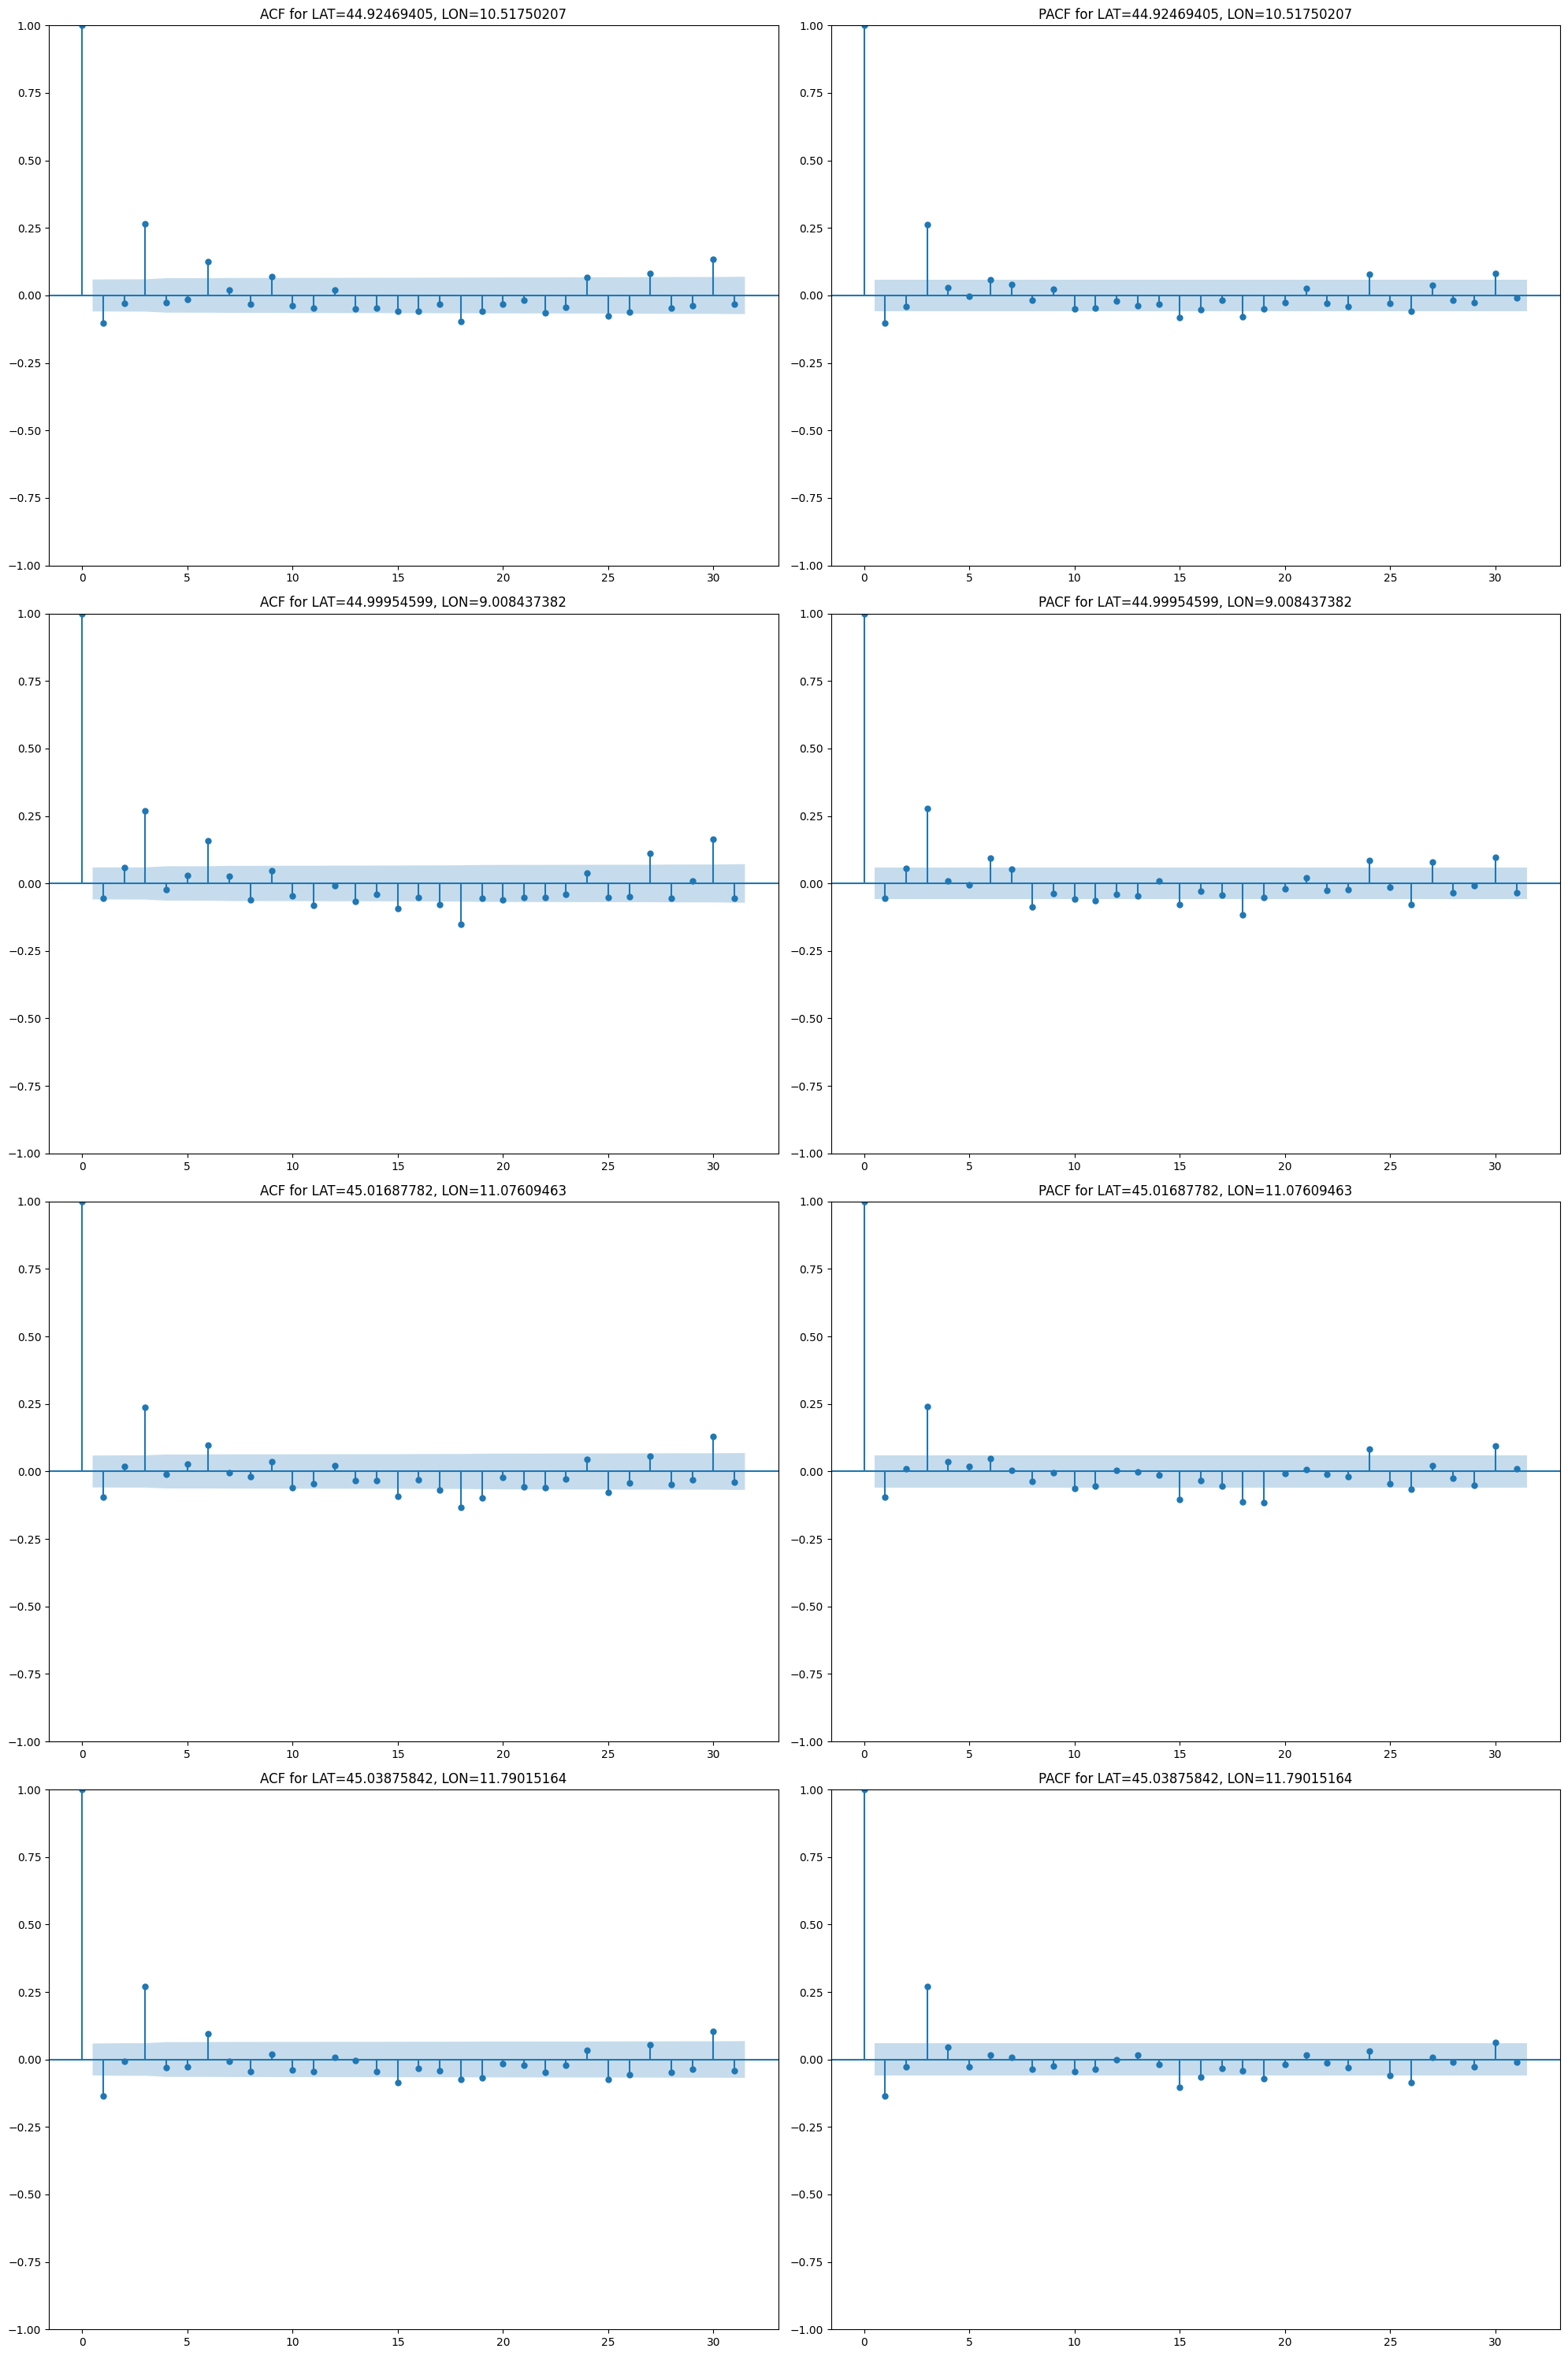

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#AAI
# Create a figure with subplots
num_rows = 4  # Number of groups to display
num_cols = 2  # Two columns for ACF and PACF plots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 30))  # Adjust figsize as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over the first four groups and plot ACF and PACF
for i, (name, group) in enumerate(grouped):
    if i >= num_rows:
        break
    group = group.sort_values(by='Date')
    ts = group['AAI']
    
    # Plot ACF
    plot_acf(ts, ax=axes[i*2])
    axes[i*2].set_title(f'ACF for LAT={name[0]}, LON={name[1]}')
    
    # Plot PACF
    plot_pacf(ts, ax=axes[i*2+1])
    axes[i*2+1].set_title(f'PACF for LAT={name[0]}, LON={name[1]}')

# Adjust layout
plt.tight_layout()
plt.show()

#AAI -Lag 3 is best

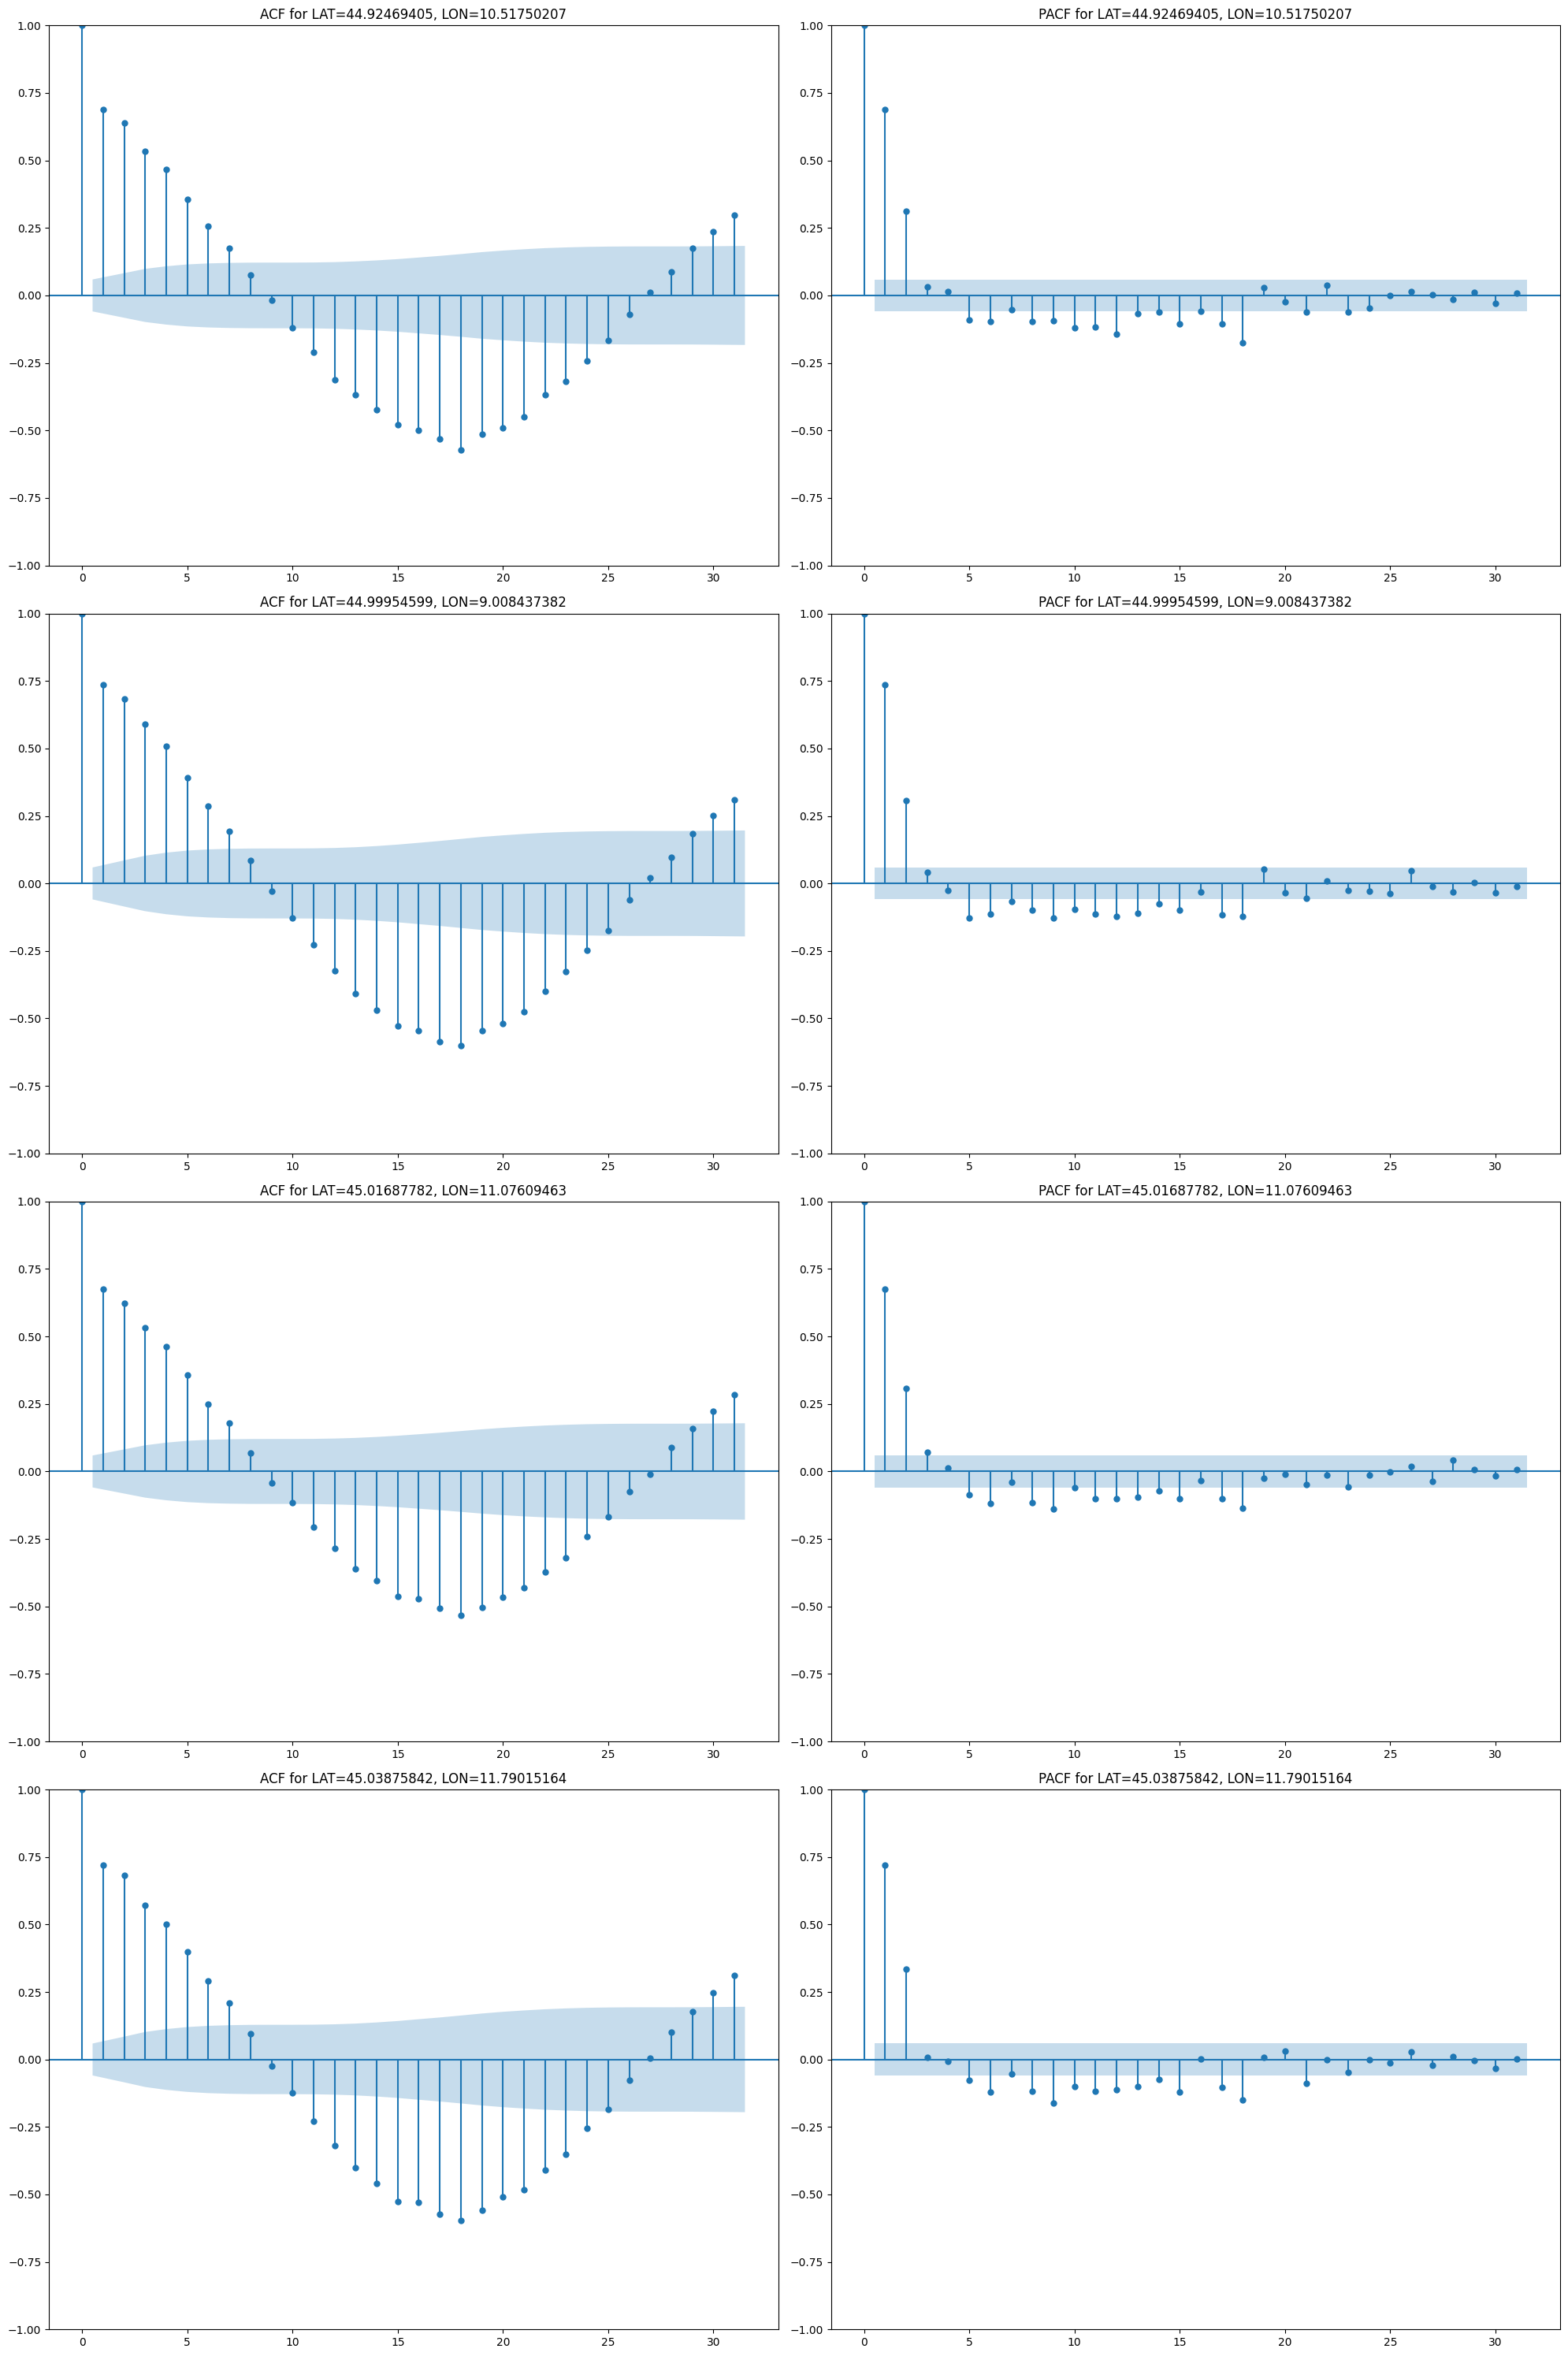

In [26]:
# Create a figure with subplots
#LST
num_rows = 4  # Number of groups to display
num_cols = 2  # Two columns for ACF and PACF plots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 30))  # Adjust figsize as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over the first four groups and plot ACF and PACF
for i, (name, group) in enumerate(grouped):
    if i >= num_rows:
        break
    group = group.sort_values(by='Date')
    ts = group['LST']
    
    # Plot ACF
    plot_acf(ts, ax=axes[i*2])
    axes[i*2].set_title(f'ACF for LAT={name[0]}, LON={name[1]}')
    
    # Plot PACF
    plot_pacf(ts, ax=axes[i*2+1])
    axes[i*2+1].set_title(f'PACF for LAT={name[0]}, LON={name[1]}')

# Adjust layout
plt.tight_layout()
plt.show()

#LST-Lag 1

In [29]:
train_model3_df_prep_mix_roll_wind_mean_stddev_sorted.columns

Index(['LAT', 'LON', 'Precipitation', 'LST', 'AAI', 'CloudFraction',
       'NO2_strat', 'NO2_total', 'NO2_trop', 'TropopausePressure', 'Date',
       'PK', 'Rolling_Mean_Precipitation', 'Rolling_Stddev_Precipitation',
       'Rolling_Mean_LST', 'Rolling_Stddev_LST', 'Rolling_Mean_AAI',
       'Rolling_Stddev_AAI', 'Rolling_Mean_CloudFraction',
       'Rolling_Stddev_CloudFraction', 'Rolling_Mean_NO2_strat',
       'Rolling_Stddev_NO2_strat', 'Rolling_Mean_NO2_total',
       'Rolling_Stddev_NO2_total', 'Rolling_Mean_NO2_trop',
       'Rolling_Stddev_NO2_trop', 'Rolling_Mean_TropopausePressure',
       'Rolling_Stddev_TropopausePressure'],
      dtype='object')

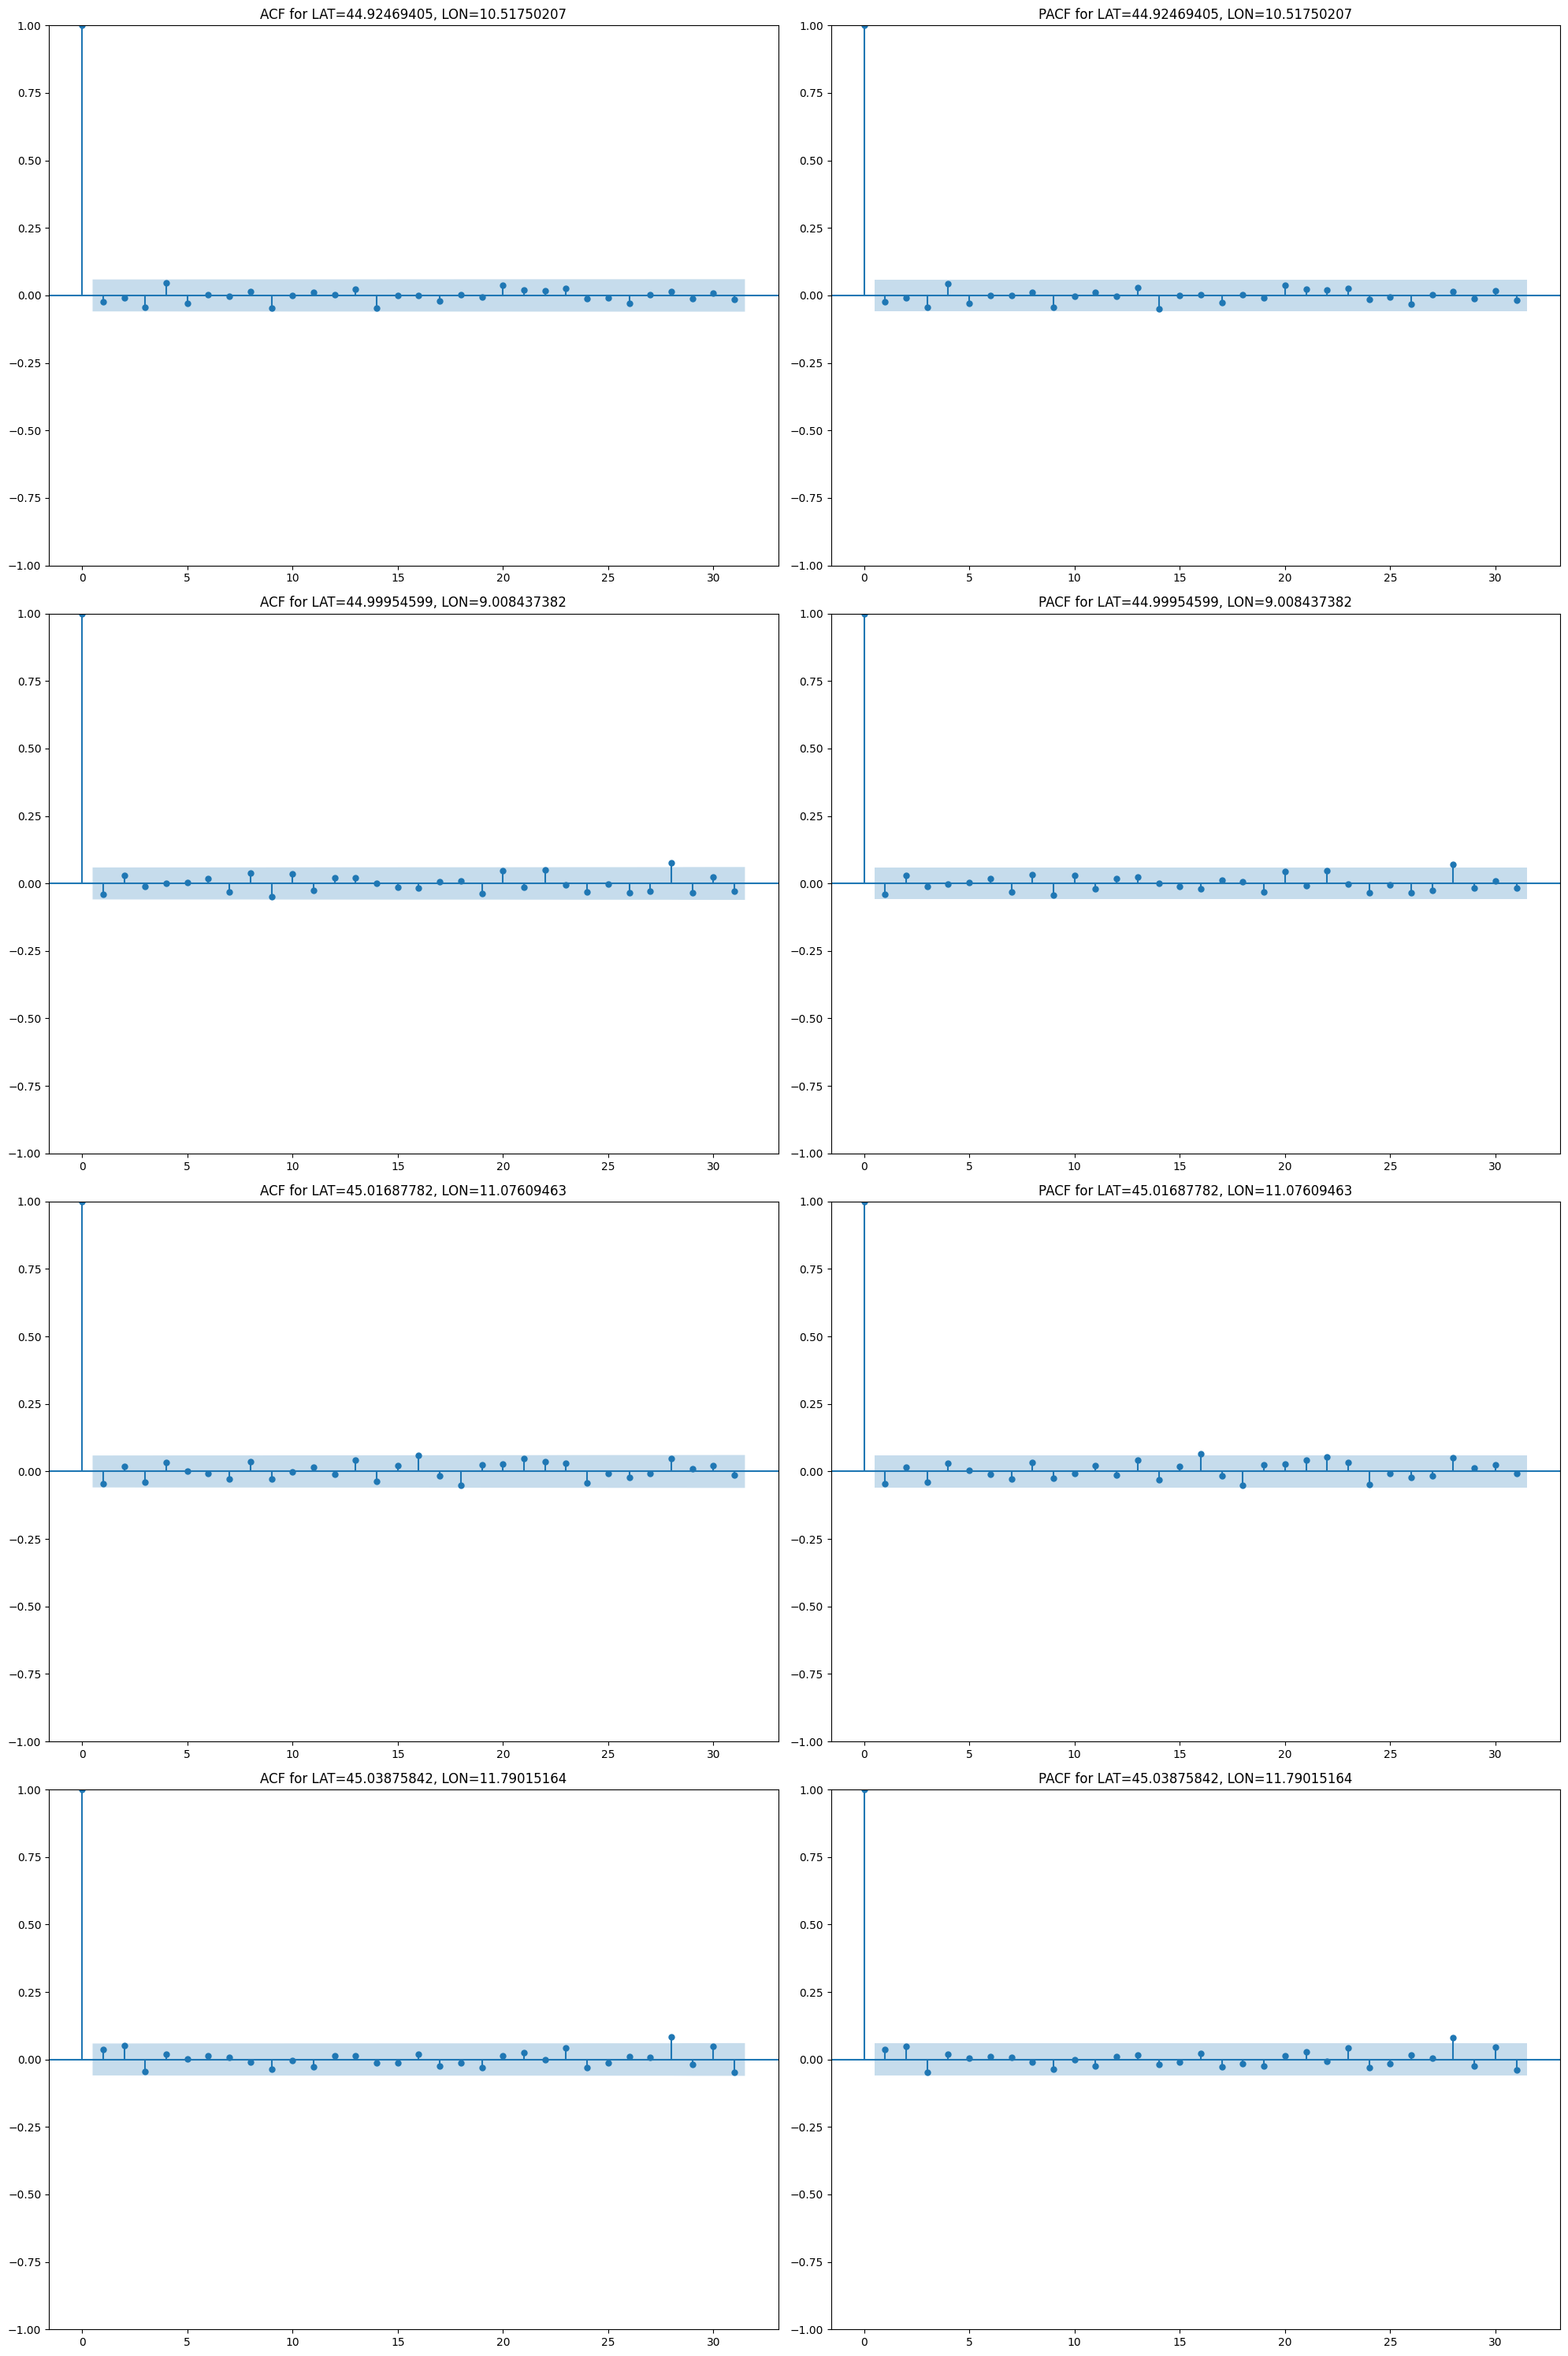

In [30]:
# Create a figure with subplots
#Precipitation
num_rows = 4  # Number of groups to display
num_cols = 2  # Two columns for ACF and PACF plots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 30))  # Adjust figsize as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over the first four groups and plot ACF and PACF
for i, (name, group) in enumerate(grouped):
    if i >= num_rows:
        break
    group = group.sort_values(by='Date')
    ts = group['Precipitation']
    
    # Plot ACF
    plot_acf(ts, ax=axes[i*2])
    axes[i*2].set_title(f'ACF for LAT={name[0]}, LON={name[1]}')
    
    # Plot PACF
    plot_pacf(ts, ax=axes[i*2+1])
    axes[i*2+1].set_title(f'PACF for LAT={name[0]}, LON={name[1]}')

# Adjust layout
plt.tight_layout()
plt.show()
#Precipitaion-No lag

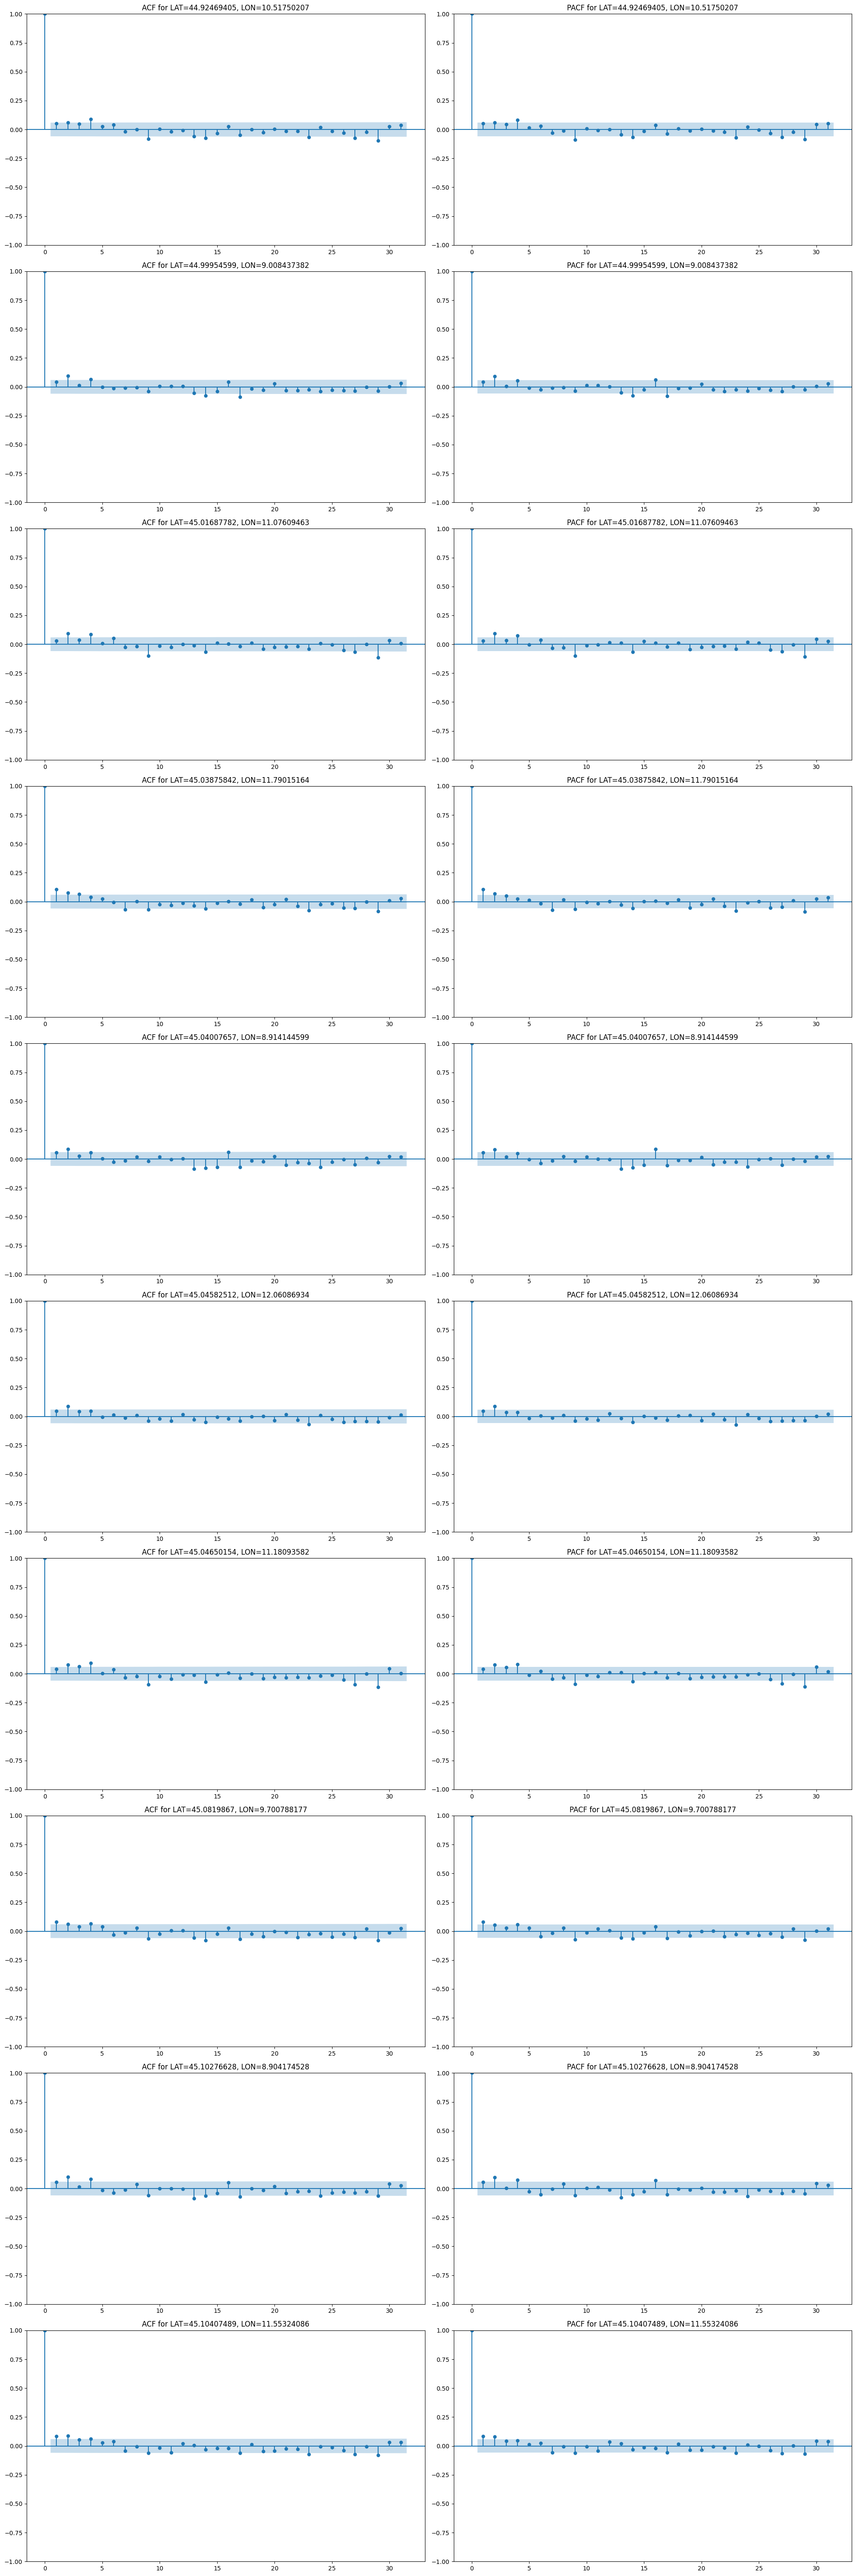

In [34]:
# Create a figure with subplots
#CloudFraction
num_rows = 10  # Number of groups to display
num_cols = 2  # Two columns for ACF and PACF plots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 60))  # Adjust figsize as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over the first four groups and plot ACF and PACF
for i, (name, group) in enumerate(grouped):
    if i >= num_rows:
        break
    group = group.sort_values(by='Date')
    ts = group['CloudFraction']
    
    # Plot ACF
    plot_acf(ts, ax=axes[i*2])
    axes[i*2].set_title(f'ACF for LAT={name[0]}, LON={name[1]}')
    
    # Plot PACF
    plot_pacf(ts, ax=axes[i*2+1])
    axes[i*2+1].set_title(f'PACF for LAT={name[0]}, LON={name[1]}')

# Adjust layout
plt.tight_layout()
plt.show()
#CloudFraction-No lag

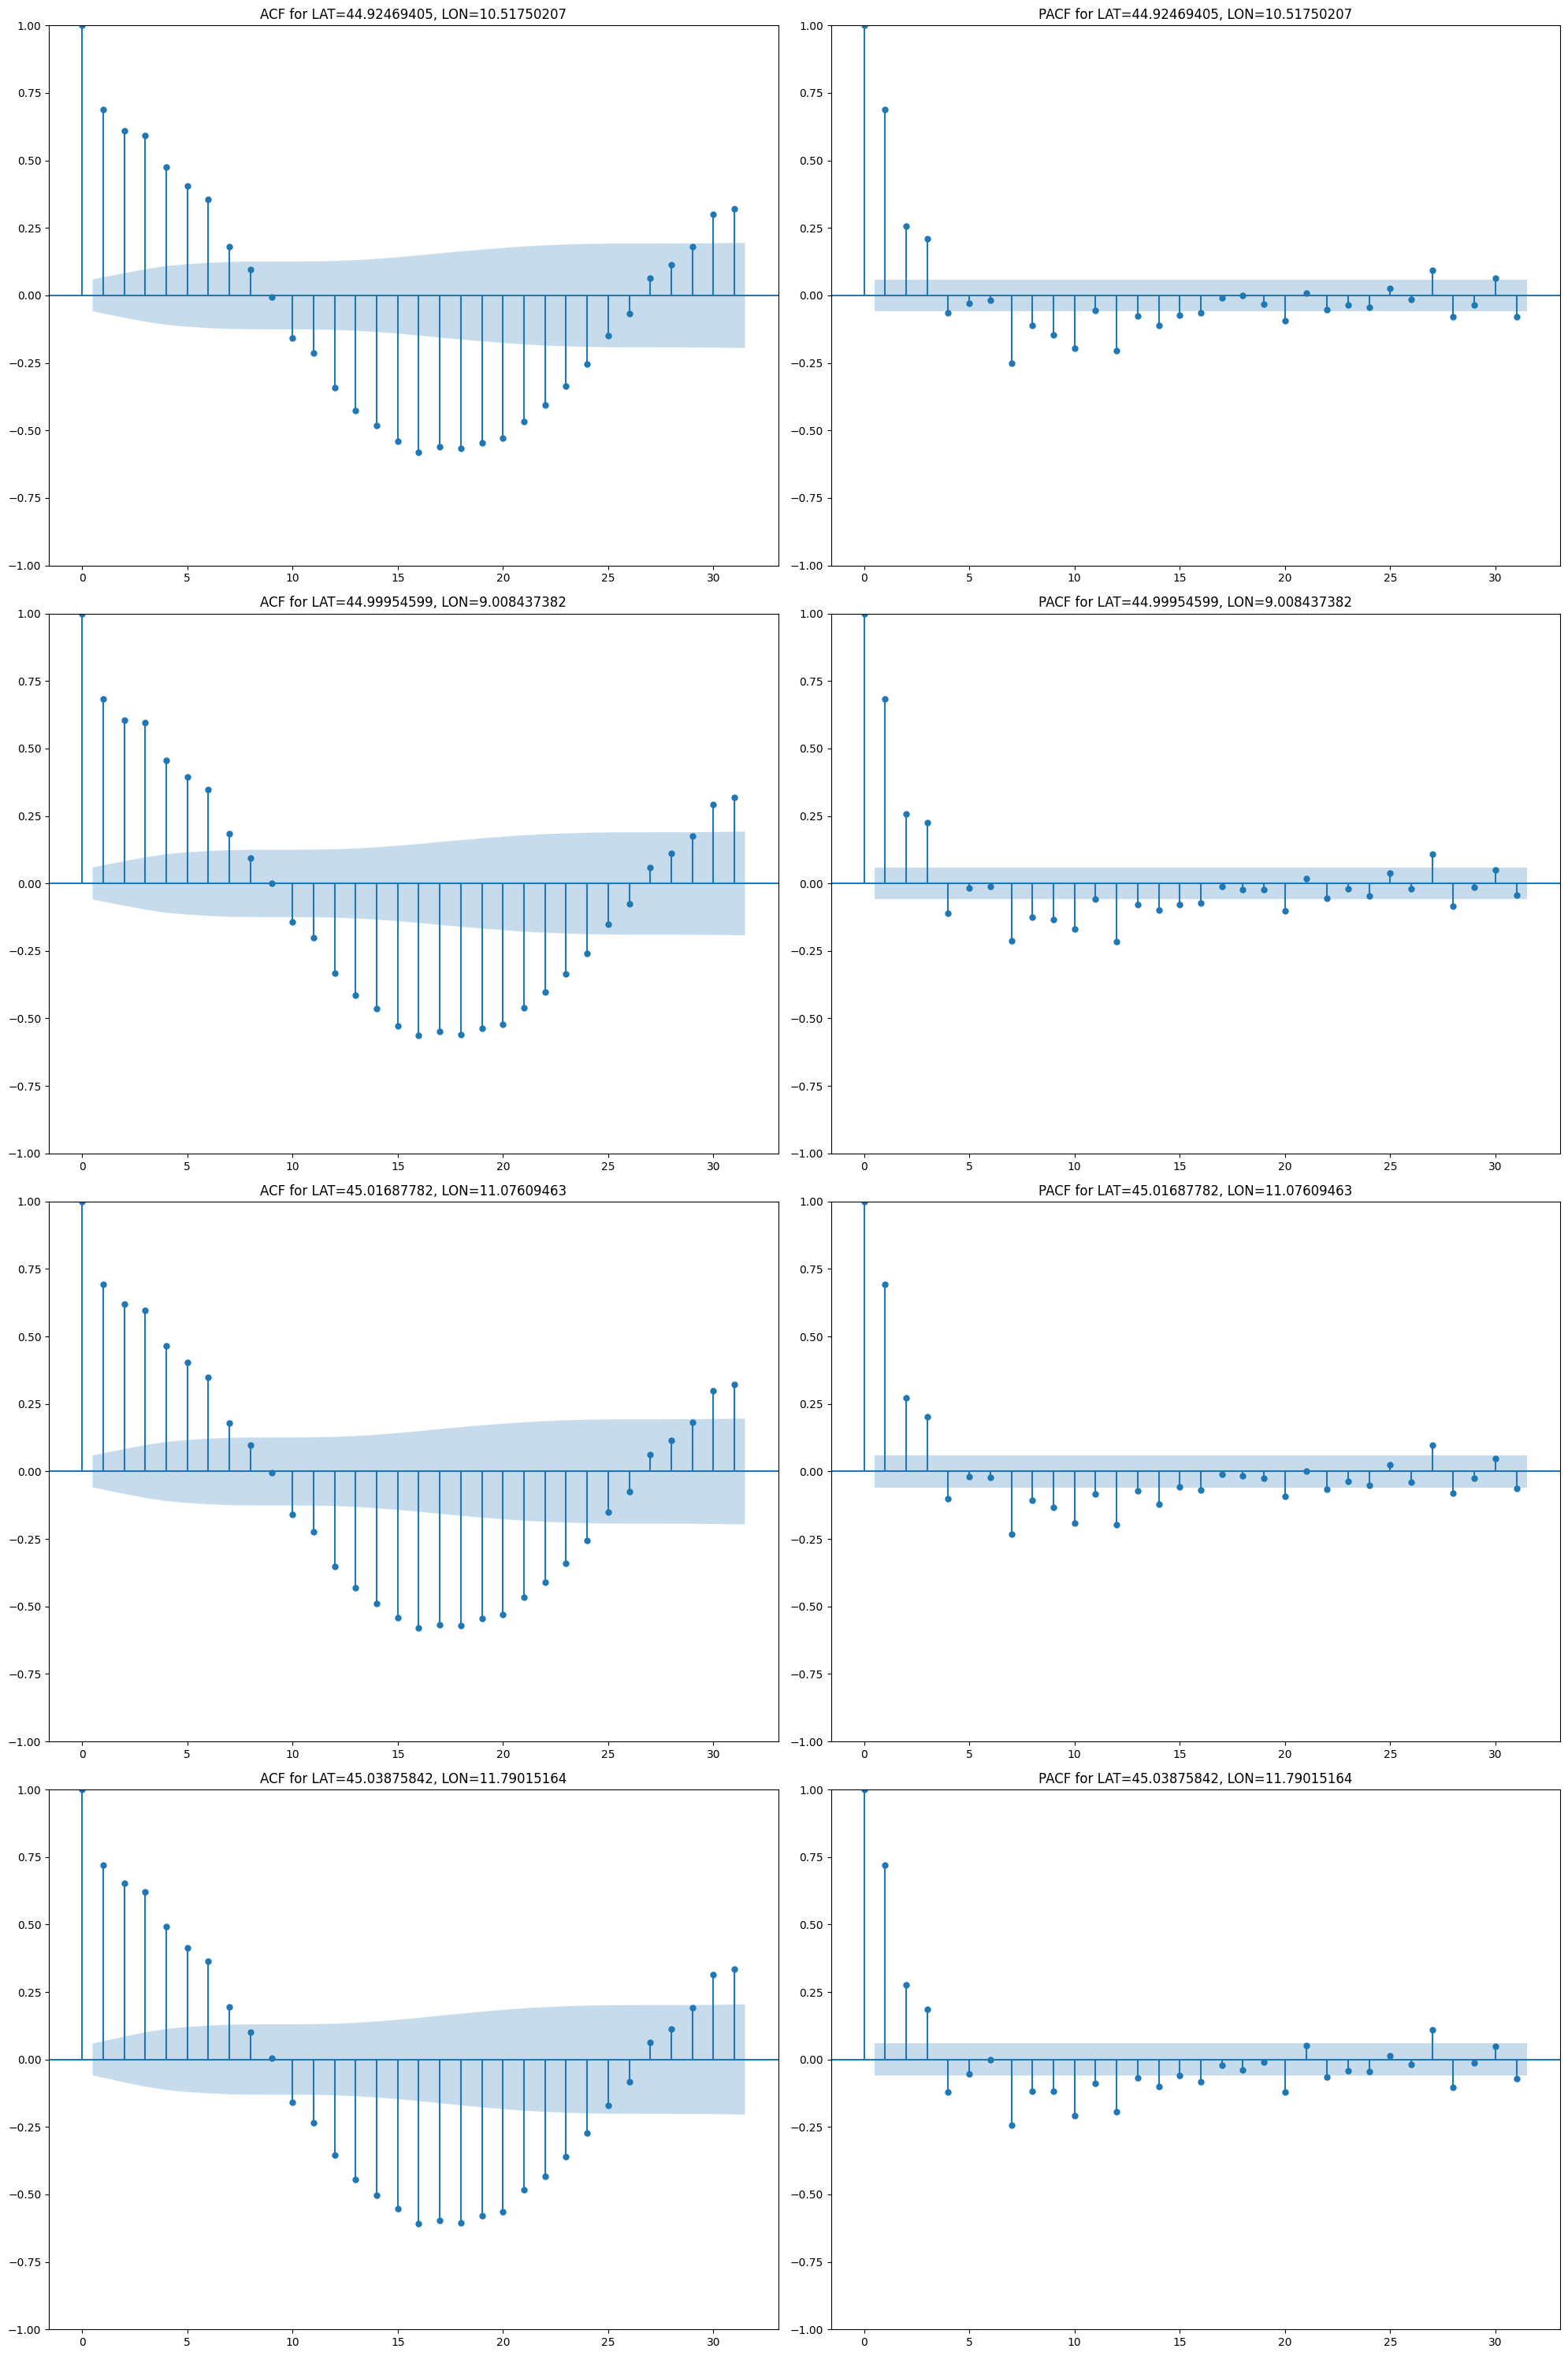

In [37]:
# Create a figure with subplots
#NO2_strat
num_rows = 4  # Number of groups to display
num_cols = 2  # Two columns for ACF and PACF plots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 30))  # Adjust figsize as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over the first four groups and plot ACF and PACF
for i, (name, group) in enumerate(grouped):
    if i >= num_rows:
        break
    group = group.sort_values(by='Date')
    ts = group['NO2_strat']
    
    # Plot ACF
    plot_acf(ts, ax=axes[i*2])
    axes[i*2].set_title(f'ACF for LAT={name[0]}, LON={name[1]}')
    
    # Plot PACF
    plot_pacf(ts, ax=axes[i*2+1])
    axes[i*2+1].set_title(f'PACF for LAT={name[0]}, LON={name[1]}')

# Adjust layout
plt.tight_layout()
plt.show()
#NO2_strat-1

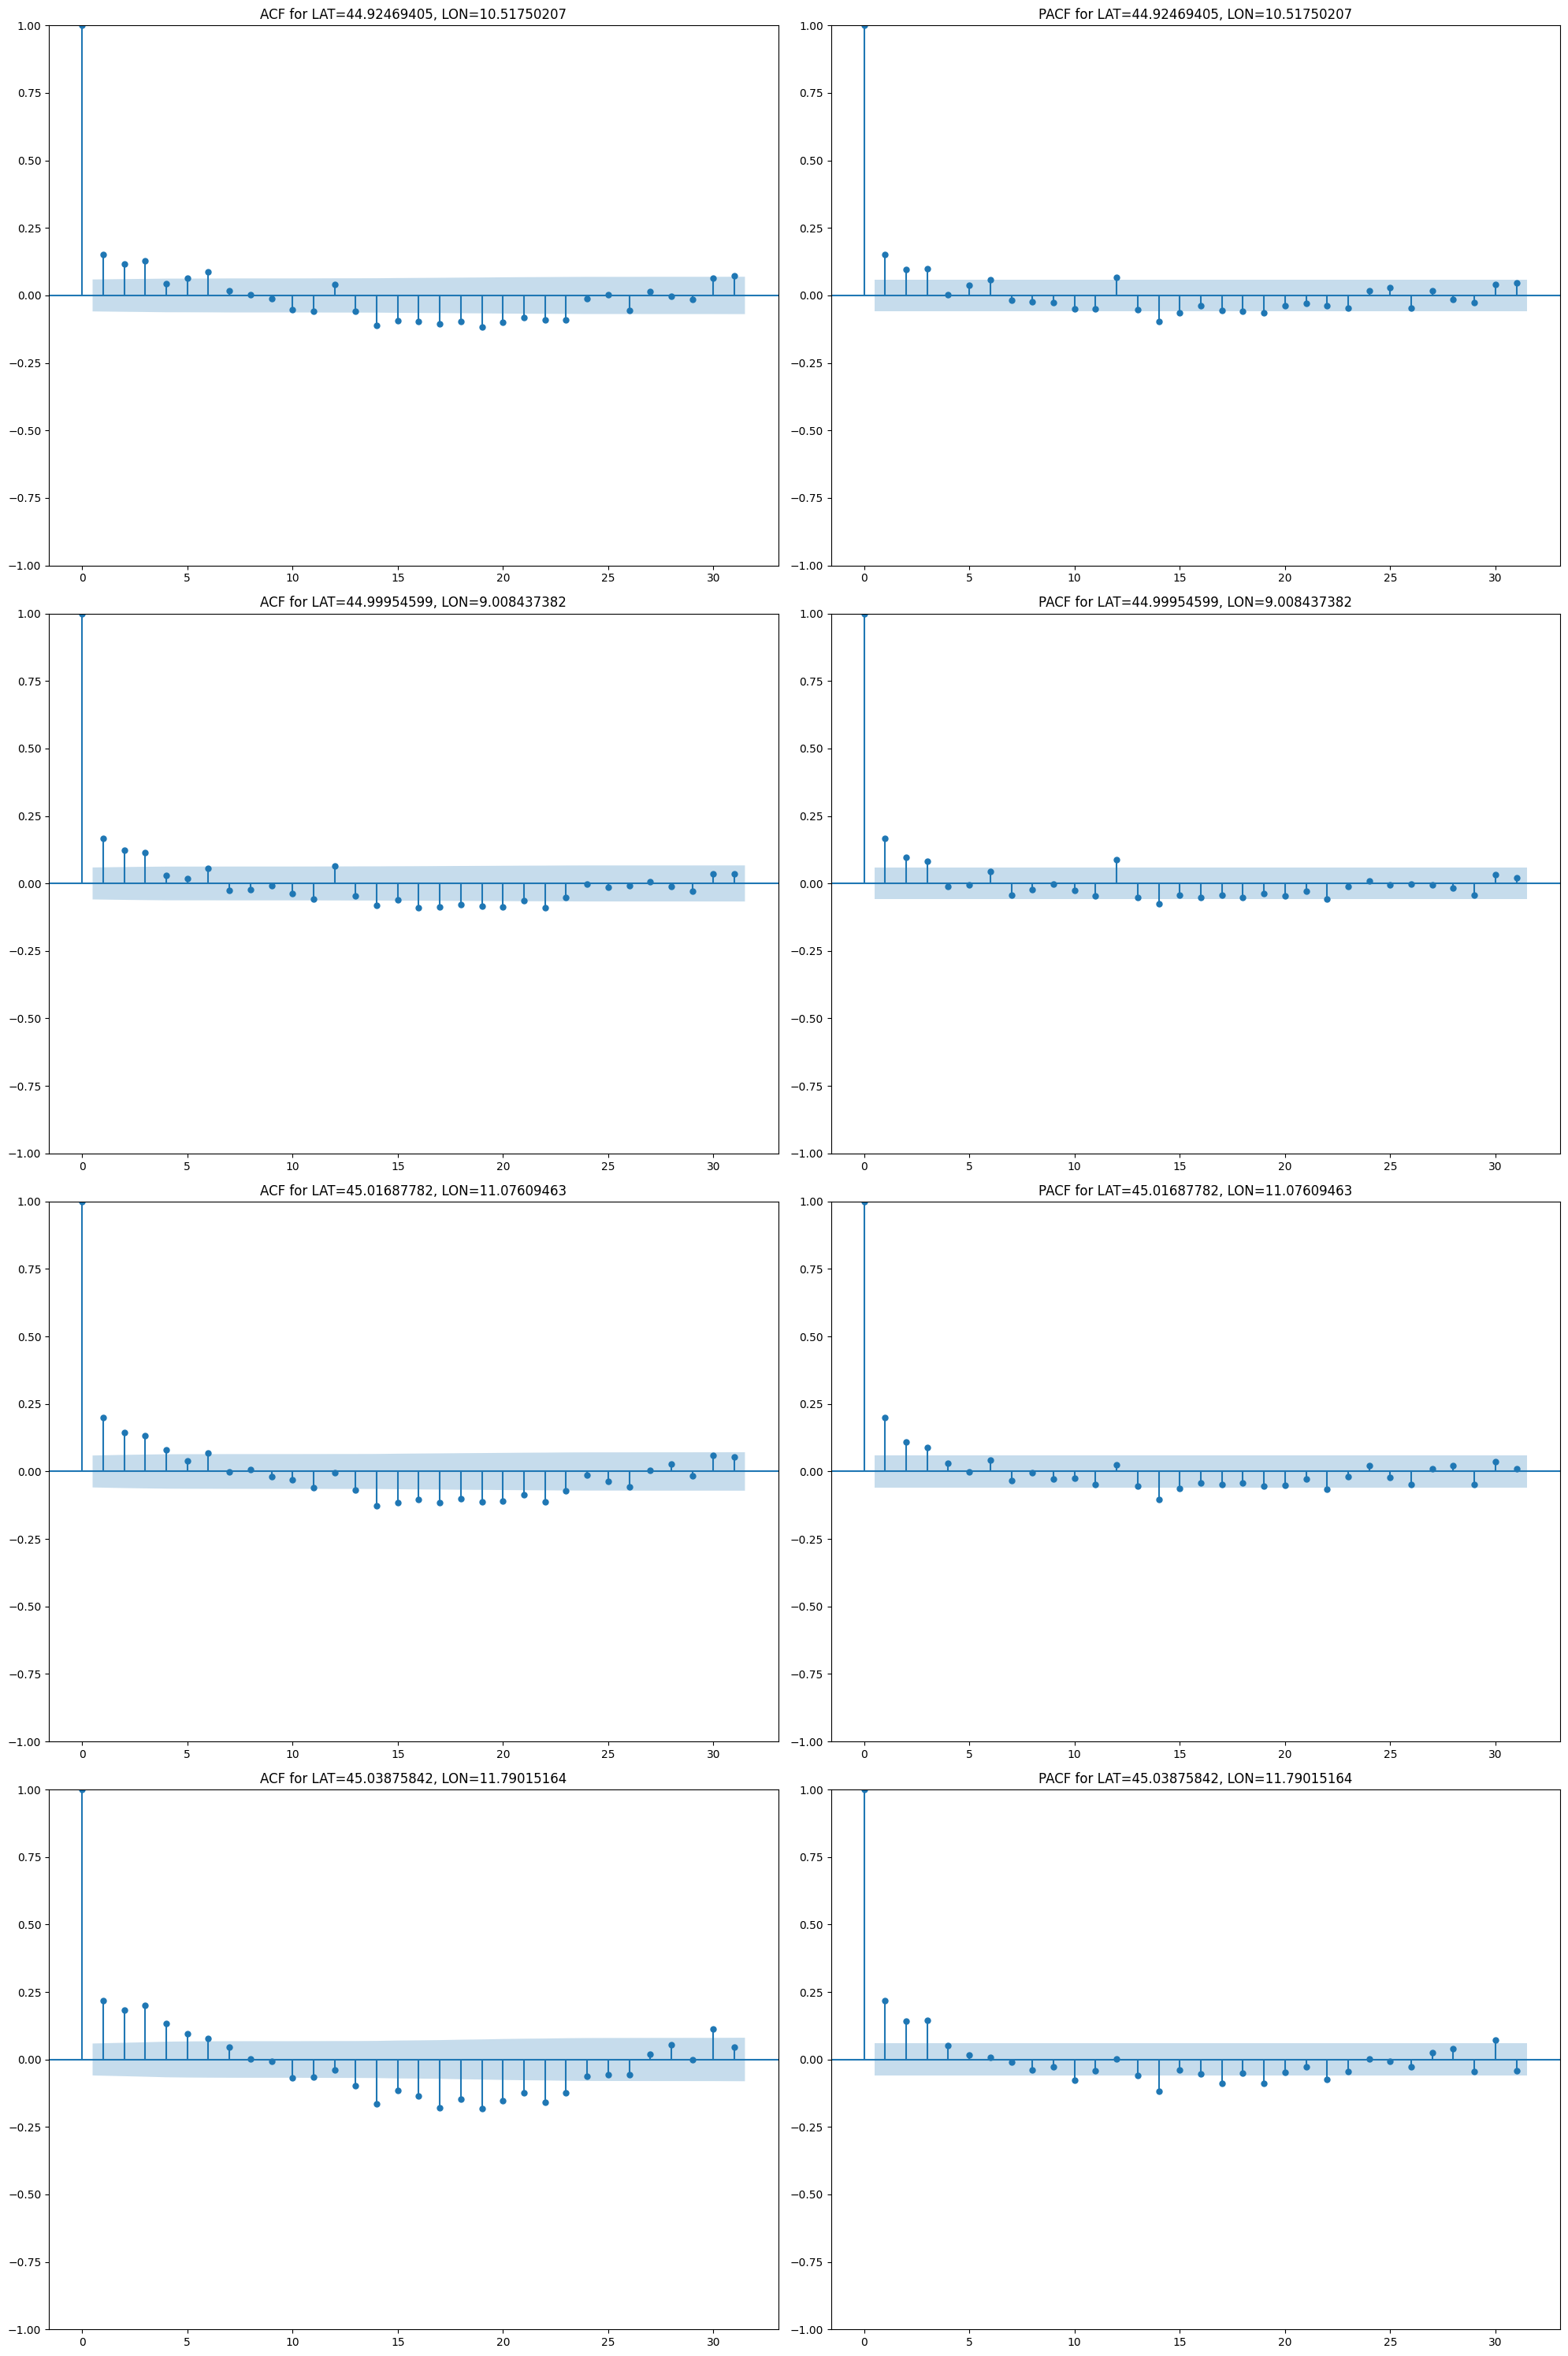

In [38]:
# Create a figure with subplots
#NO2_total
num_rows = 4  # Number of groups to display
num_cols = 2  # Two columns for ACF and PACF plots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 30))  # Adjust figsize as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over the first four groups and plot ACF and PACF
for i, (name, group) in enumerate(grouped):
    if i >= num_rows:
        break
    group = group.sort_values(by='Date')
    ts = group['NO2_total']
    
    # Plot ACF
    plot_acf(ts, ax=axes[i*2])
    axes[i*2].set_title(f'ACF for LAT={name[0]}, LON={name[1]}')
    
    # Plot PACF
    plot_pacf(ts, ax=axes[i*2+1])
    axes[i*2+1].set_title(f'PACF for LAT={name[0]}, LON={name[1]}')

# Adjust layout
plt.tight_layout()
plt.show()
#NO2_total-1

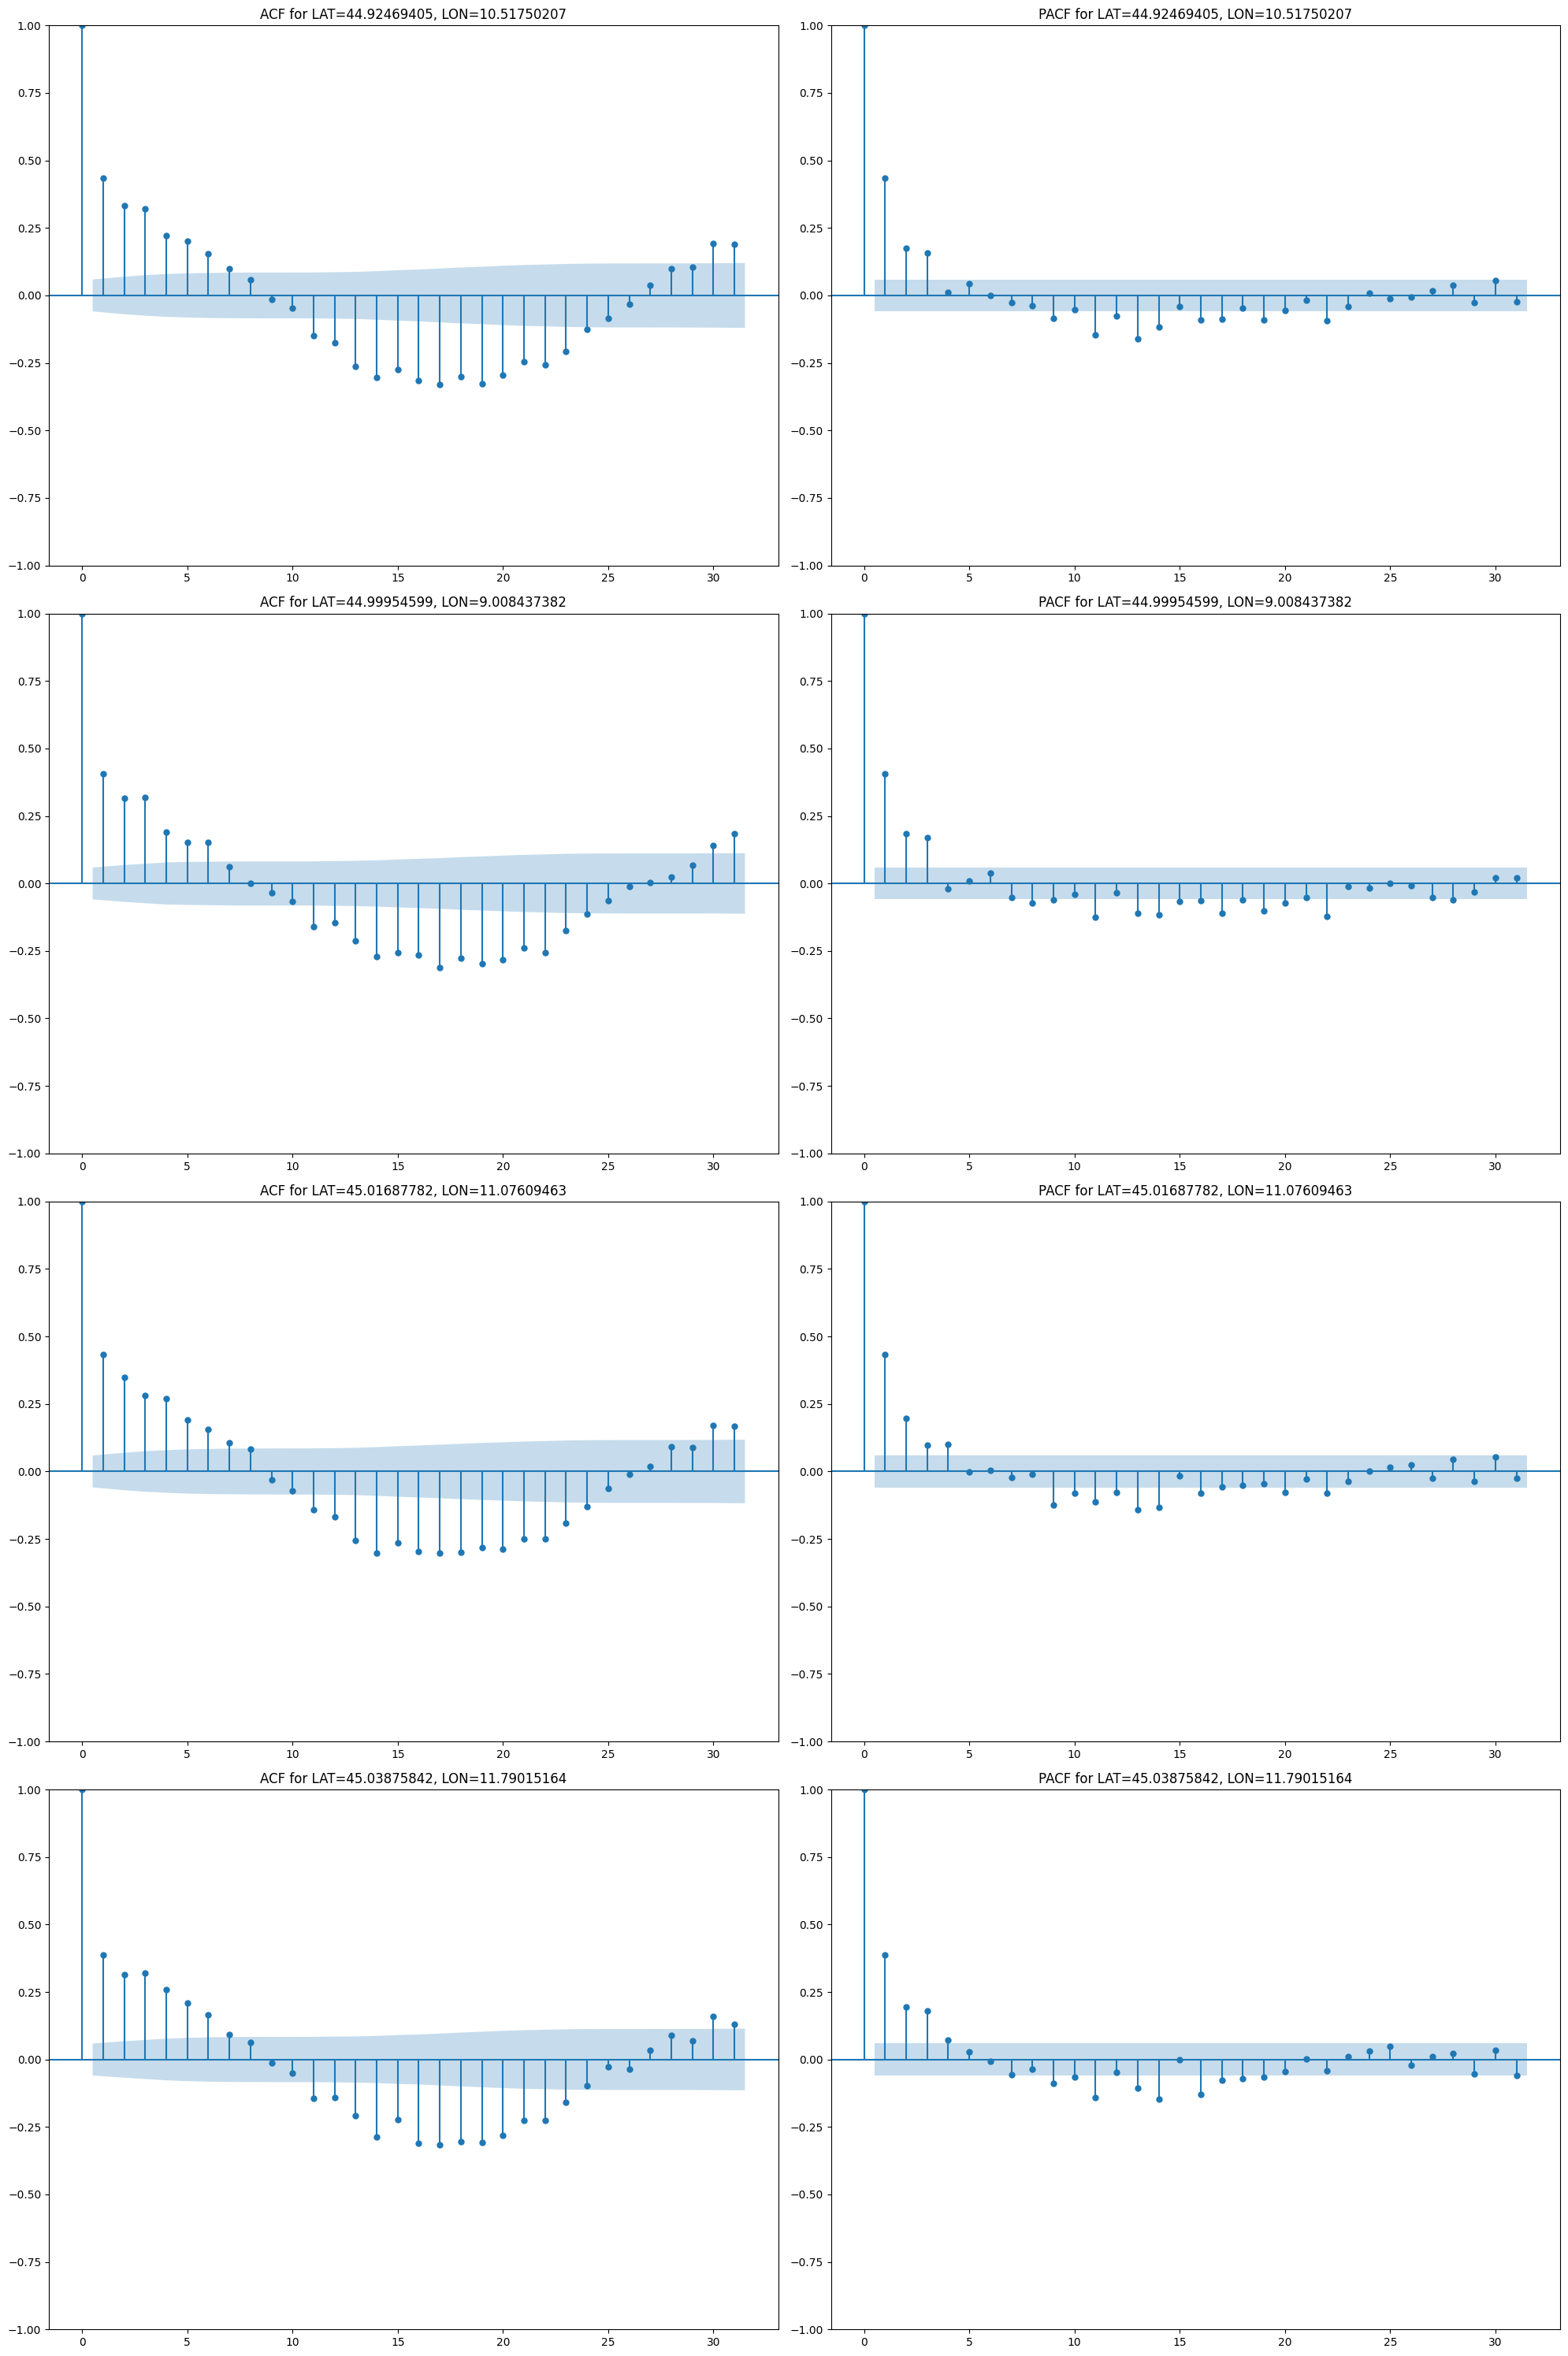

In [39]:
# Create a figure with subplots
#NO2_trop
num_rows = 4  # Number of groups to display
num_cols = 2  # Two columns for ACF and PACF plots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 30))  # Adjust figsize as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over the first four groups and plot ACF and PACF
for i, (name, group) in enumerate(grouped):
    if i >= num_rows:
        break
    group = group.sort_values(by='Date')
    ts = group['NO2_trop']
    
    # Plot ACF
    plot_acf(ts, ax=axes[i*2])
    axes[i*2].set_title(f'ACF for LAT={name[0]}, LON={name[1]}')
    
    # Plot PACF
    plot_pacf(ts, ax=axes[i*2+1])
    axes[i*2+1].set_title(f'PACF for LAT={name[0]}, LON={name[1]}')

# Adjust layout
plt.tight_layout()
plt.show()
#NO2_trop-1

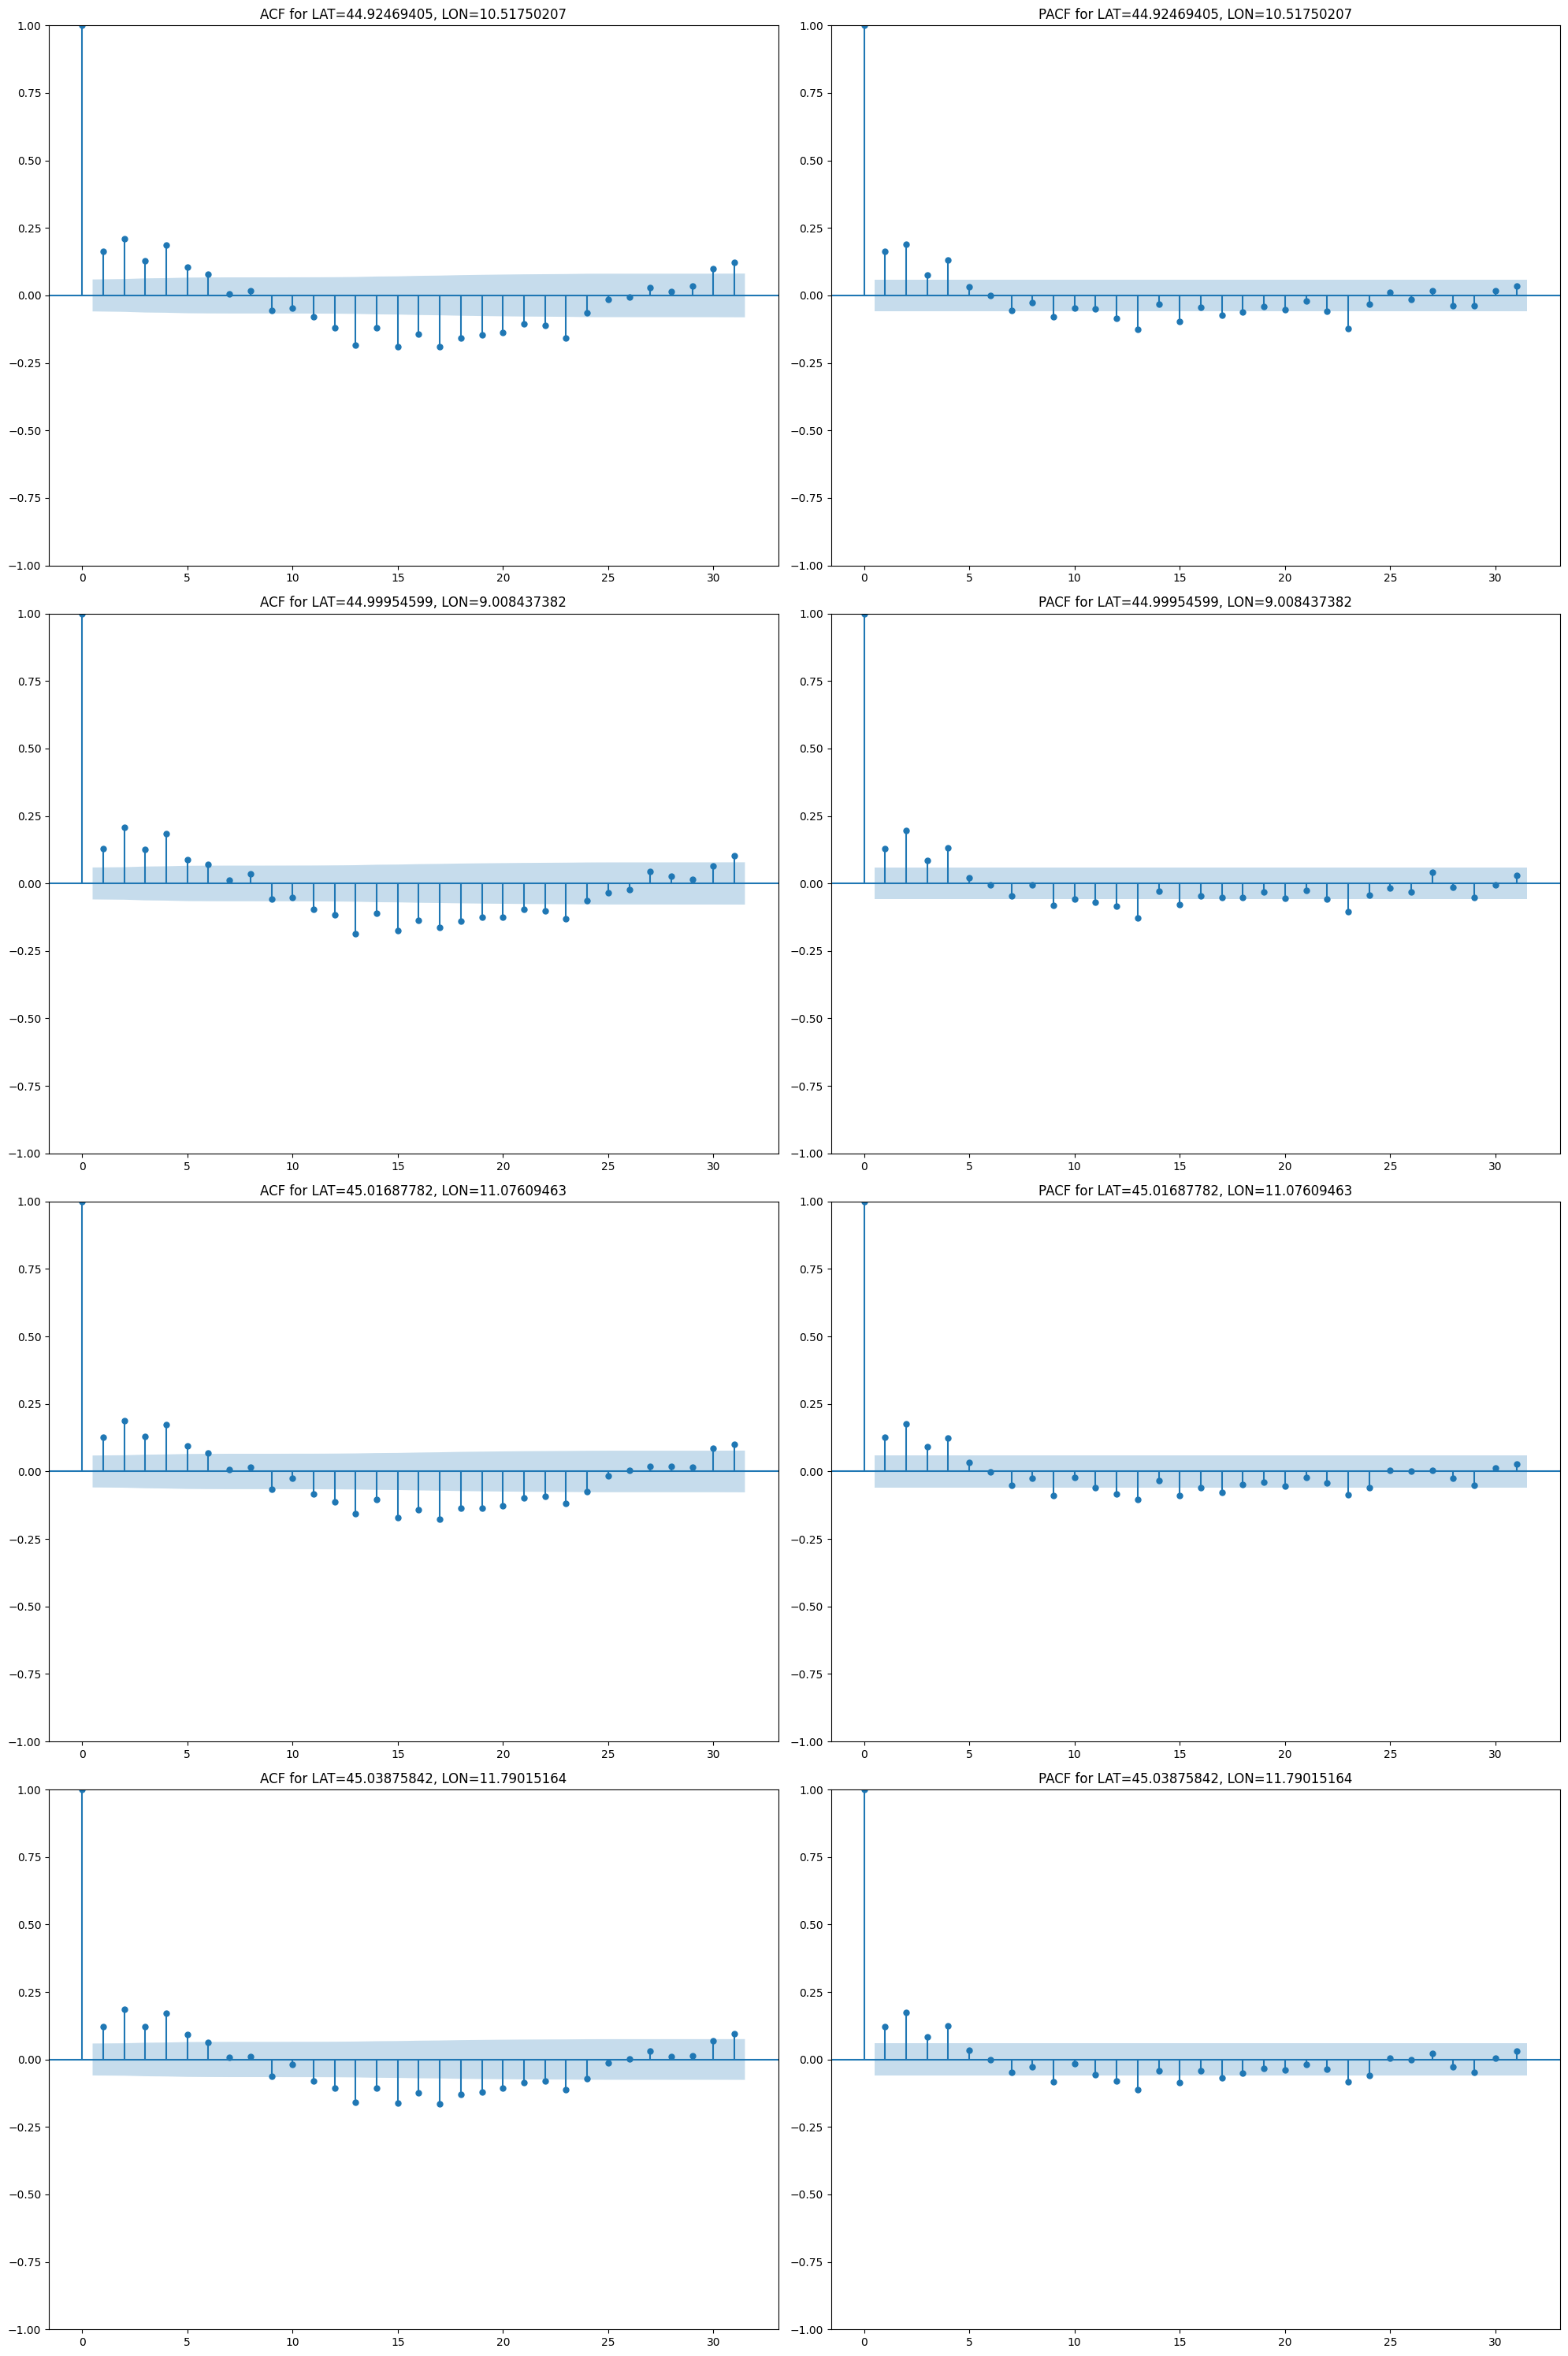

In [40]:
# Create a figure with subplots
#TropopausePressure
num_rows = 4  # Number of groups to display
num_cols = 2  # Two columns for ACF and PACF plots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 30))  # Adjust figsize as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over the first four groups and plot ACF and PACF
for i, (name, group) in enumerate(grouped):
    if i >= num_rows:
        break
    group = group.sort_values(by='Date')
    ts = group['TropopausePressure']
    
    # Plot ACF
    plot_acf(ts, ax=axes[i*2])
    axes[i*2].set_title(f'ACF for LAT={name[0]}, LON={name[1]}')
    
    # Plot PACF
    plot_pacf(ts, ax=axes[i*2+1])
    axes[i*2+1].set_title(f'PACF for LAT={name[0]}, LON={name[1]}')

# Adjust layout
plt.tight_layout()
plt.show()
#TropopausePressure-2